In [97]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import sys
import os
from pathlib import Path
import glob
import h5py

In [2]:
# Add project root directory to make imports possible
project_root = Path("/lustre/work/akira.tokiwa/Projects/LensingSSC")
sys.path.append(str(project_root))

In [3]:
from lensing_ssc.utils.io import load_results_from_hdf5
from lensing_ssc.core.fibonacci.fibonacci import FibonacciGrid
from lensing_ssc.core.fibonacci.optimizer import PatchOptimizer
from lensing_ssc.core.fibonacci.plotting import plot_coverage_map, plot_fibonacci_grid
from lensing_ssc.core.fibonacci.coverage import CoverageAnalyzer

In [4]:
# Jupyter plotting settings
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [15, 10]

In [ ]:
# Parameter settings
nside = 512  # Healpix resolution (in actual analysis, 1024 is used, but set to lower resolution for faster display)
patch_size = 10  # Patch size (degrees)
Ninit = 265  # Upper limit of initial patch count

# Directory to save results
results_dir = project_root / "output" 
savedir = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/figures"
os.makedirs(results_dir, exist_ok=True)


In [190]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=67.74, Om0=0.309)
sboxsize = 625
bboxsize = 5000

# Configuration

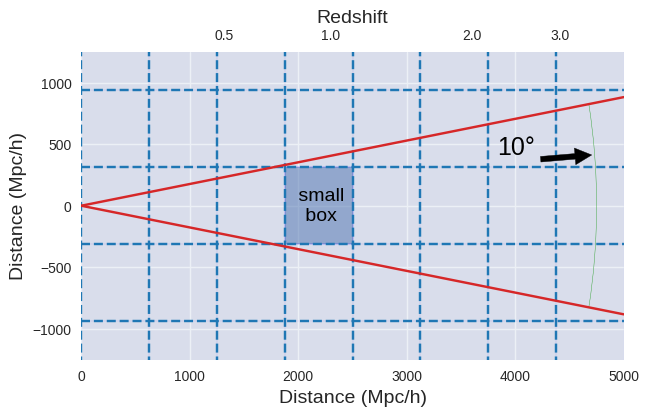

In [191]:
from matplotlib.patches import Arc  

# Parameters
replications = bboxsize // sboxsize

# Convert opening angle to radians
opening_angle_rad = np.deg2rad(patch_size)

# Calculate the extent of the light cone in x and y directions
extent = bboxsize * np.tan(opening_angle_rad)

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 4))

# Draw the replicated boxes
for i in range(replications):
    ax.vlines(x=i * sboxsize, ymin=-bboxsize / 2, ymax=bboxsize / 2, color='tab:blue', linestyle='--')

for i in range(4):
    ax.hlines(y=(i+0.5) * sboxsize, xmin=0, xmax=bboxsize, color='tab:blue', linestyle='--')
    ax.hlines(y=-(i+0.5) * sboxsize, xmin=0, xmax=bboxsize, color='tab:blue', linestyle='--')

for i in range(replications):
    for j in range(4):
        rect = plt.Rectangle((i * sboxsize, -sboxsize/2 + j * sboxsize), sboxsize, sboxsize, edgecolor='blue', linestyle='-', fill=True, alpha=0.1)
        ax.add_patch(rect)
        if j != 0:
            rect = plt.Rectangle((i * sboxsize, -sboxsize/2 - j * sboxsize), sboxsize, sboxsize, edgecolor='blue', linestyle='-', fill=True, alpha=0.1)
            ax.add_patch(rect)

rect = plt.Rectangle((3 * sboxsize, -sboxsize/2), sboxsize, sboxsize, edgecolor='blue', linestyle='-', fill=True, alpha=0.5)
ax.add_patch(rect)
ax.text(3 * sboxsize + sboxsize/2, 0, ' small\n box', fontsize=14, color='black', ha='center', va='center')
    
# Draw the light cone
x_coords = [0, bboxsize]
y_coords = [0, extent]
ax.plot(x_coords, y_coords, color='tab:red')

x_coords = [0, bboxsize]
y_coords = [0, -extent]
ax.plot(x_coords, y_coords, color='tab:red')

# Add the opening angle arc
arc = Arc((0, 0), width=bboxsize*1.9, height=1.9*bboxsize, angle=0,
        theta1=-patch_size, theta2=patch_size, color='tab:green')
ax.add_patch(arc)

# Add the opening angle annotation
arc_radius = bboxsize*0.95
arc_x = arc_radius * np.cos(opening_angle_rad / 2)
arc_y = arc_radius * np.sin(opening_angle_rad / 2)
ax.annotate(f'{patch_size}°',
            xy=(arc_x, arc_y),
            xytext=(arc_x - 900, arc_y - 0),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=18,
            color='black')

# Set limits and labels
ax.set_xlim(0, bboxsize)
ax.set_ylim(-bboxsize / 4, bboxsize / 4)
ax.set_xlabel('Distance (Mpc/h)', fontsize=14)
ax.set_ylabel('Distance (Mpc/h)', fontsize=14)
#ax.set_title('Concept Figure of a Light Cone Configuration')


# Create a secondary x-axis for redshift
secax = ax.secondary_xaxis('top')
secax.set_xlabel('Redshift', fontsize=14)
redshift_ticks = [0.5, 1.0, 2.0, 3.0]
distance_ticks = [cosmo.comoving_distance(z).value * cosmo.h for z in redshift_ticks]
secax.set_xticks(distance_ticks)
secax.set_xticklabels(redshift_ticks)

# save the figure
plt.savefig(f'{savedir}/light_cone_configuration.png', bbox_inches='tight')

# Fibonacci

Optimal number of patches: 273


/var/tmp/pbs.414522.idark/ipykernel_251444/2253411221.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


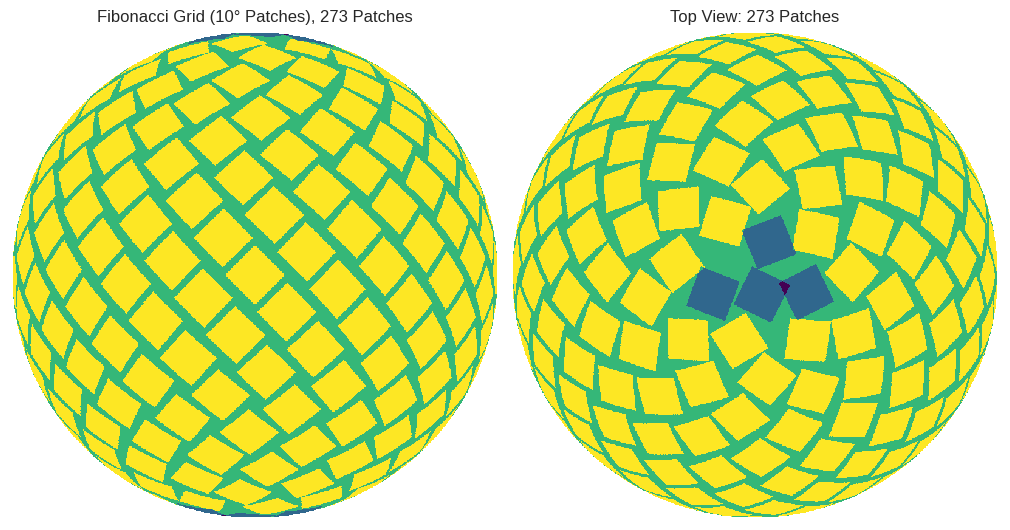

In [6]:

# Create optimizer
optimizer = PatchOptimizer(nside=nside, patch_size=patch_size, Ninit=Ninit)

# Calculate optimal number of patches (verbose=True to show progress)
N_opt = FibonacciGrid.load_or_generate_points(patch_size, None).shape[0]
print(f"Optimal number of patches: {N_opt}")

# Visualize basic Fibonacci grid
fig, pixels = plot_fibonacci_grid(optimizer, n=N_opt)
#plt.suptitle(f"Basic Fibonacci Grid (Patch size: {patch_size}°, Optimal patches: {N_opt})", fontsize=16)
plt.tight_layout()
plt.savefig(results_dir / f"basic_fibonacci_grid_{patch_size}deg.png", dpi=300, bbox_inches='tight')
plt.show()


Coverage rate for Scenario 1: 64.42%
Coverage rate for Scenario 2: 47.16%


/var/tmp/pbs.414522.idark/ipykernel_251444/2175943240.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


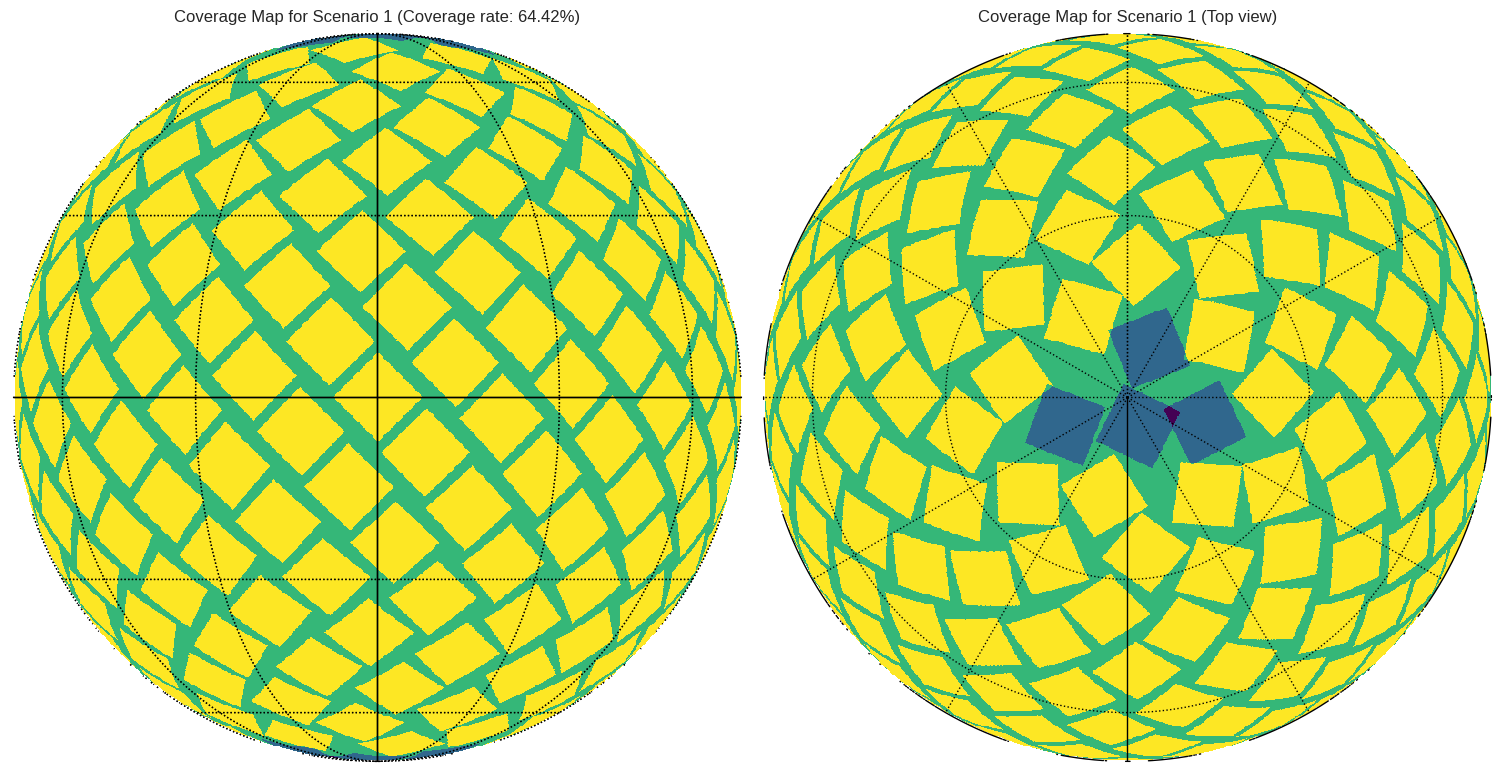

/var/tmp/pbs.414522.idark/ipykernel_251444/2175943240.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


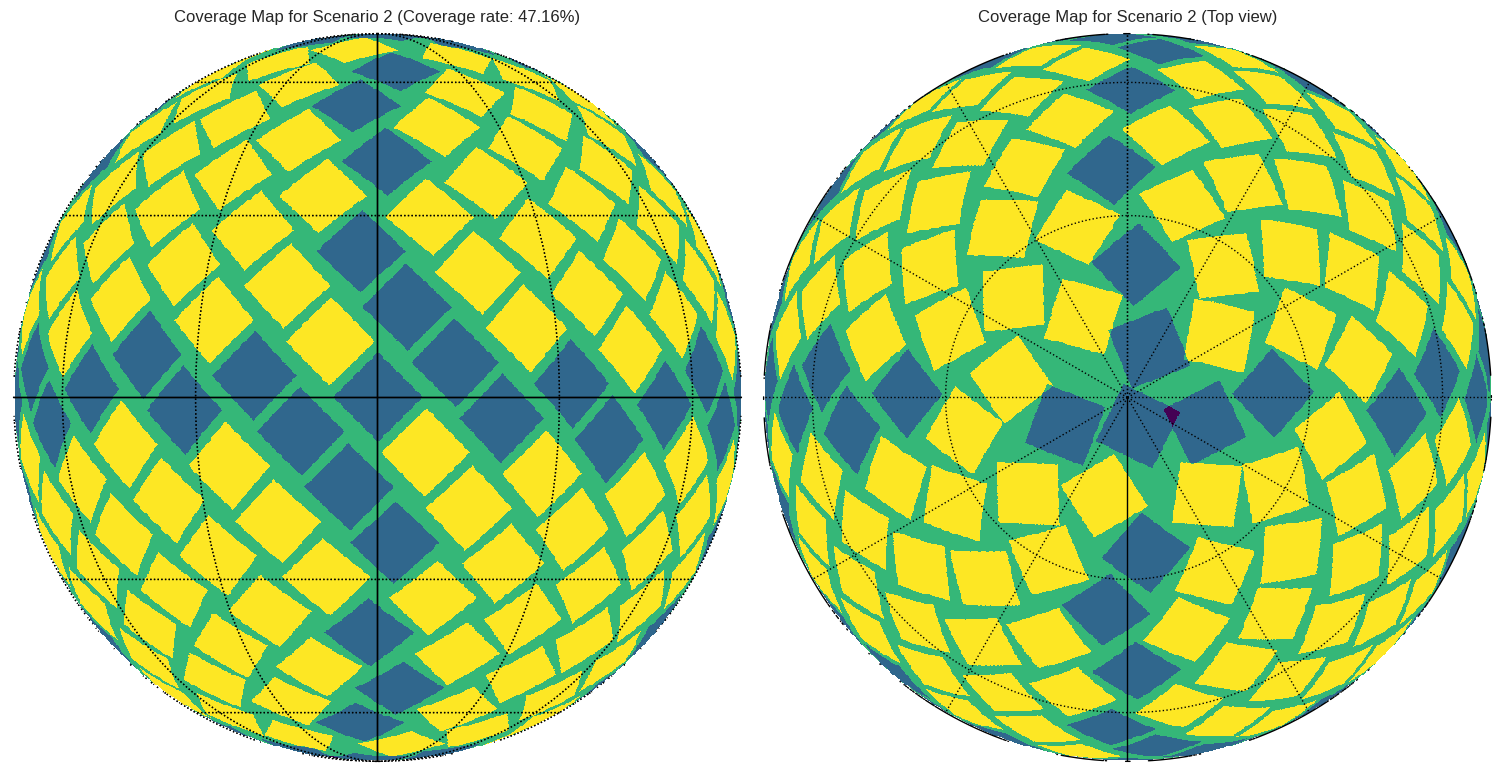

In [7]:
# Create coverage maps for each scenario
points = FibonacciGrid.fibonacci_grid_on_sphere(N_opt)

# Scenario 1: Exclude patches near the poles
mask1 = CoverageAnalyzer.build_mask_first_scenario(points, optimizer)
valid_points1 = points[~mask1]
invalid_points1 = points[mask1]

# Scenario 2: More complex masking condition
mask2 = CoverageAnalyzer.build_mask_second_scenario(points, optimizer)
valid_points2 = points[~mask2]
invalid_points2 = points[mask2]

# Create coverage maps
npix = hp.nside2npix(optimizer.nside)
coverage_map1 = np.zeros(npix, dtype=int)
coverage_map2 = np.zeros(npix, dtype=int)

# Fill coverage maps
CoverageAnalyzer.fill_coverage_map(valid_points1, invalid_points1, optimizer, coverage_map1)
CoverageAnalyzer.fill_coverage_map(valid_points2, invalid_points2, optimizer, coverage_map2)

# Calculate coverage statistics
coverage_fraction1 = CoverageAnalyzer.compute_coverage_stats(coverage_map1)
coverage_fraction2 = CoverageAnalyzer.compute_coverage_stats(coverage_map2)

print(f"Coverage rate for Scenario 1: {coverage_fraction1:.2%}")
print(f"Coverage rate for Scenario 2: {coverage_fraction2:.2%}")

# Display coverage map for Scenario 1
plt.figure(figsize=(15, 8))
plot_coverage_map(coverage_map1, f"Coverage Map for Scenario 1 (Coverage rate: {coverage_fraction1:.2%})", (1, 2, 1))
plot_coverage_map(coverage_map1, f"Coverage Map for Scenario 1 (Top view)", (1, 2, 2), rot=(0, 90, 0))
plt.tight_layout()
plt.savefig(results_dir / f"scenario1_coverage_{patch_size}deg.png", dpi=300, bbox_inches='tight')
plt.show()

# Display coverage map for Scenario 2
plt.figure(figsize=(15, 8))
plot_coverage_map(coverage_map2, f"Coverage Map for Scenario 2 (Coverage rate: {coverage_fraction2:.2%})", (1, 2, 1))
plot_coverage_map(coverage_map2, f"Coverage Map for Scenario 2 (Top view)", (1, 2, 2), rot=(0, 90, 0))
plt.tight_layout()
plt.savefig(results_dir / f"scenario2_coverage_{patch_size}deg.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Get indices of patches valid in scenario 1 but excluded in scenario 2

# Generate Fibonacci grid points
points = FibonacciGrid.fibonacci_grid_on_sphere(N_opt)

# Scenario 1 mask (True = invalid points)
mask1 = CoverageAnalyzer.build_mask_first_scenario(points, optimizer)
valid_idx_scenario1 = np.where(~mask1)[0]

# Scenario 2 mask (True = invalid points)
mask2 = CoverageAnalyzer.build_mask_second_scenario(points, optimizer)
valid_idx_scenario2 = np.where(~mask2)[0]

# Patches valid in scenario 1 but excluded in scenario 2
excluded_in_scenario2 = np.setdiff1d(valid_idx_scenario1, valid_idx_scenario2)

# Pattches idx, removed excluded_in_scenario2 from np.arange(len(valid_idx_scenario1))
tmp = np.arange(len(valid_idx_scenario1))
valid_idx = np.delete(tmp, excluded_in_scenario2)


print(f"Number of valid patches in scenario 1: {len(valid_idx_scenario1)}")
print(f"Number of valid patches in scenario 2: {len(valid_idx_scenario2)}")
print(f"Number of patches valid in scenario 1 but excluded in scenario 2: {len(excluded_in_scenario2)}")
print(f"Indices of excluded patches: {excluded_in_scenario2}")
print(f"Number of patches remaining after applying both scenarios: {len(valid_idx)}")
print(f"Indices of remaining patches: {valid_idx}")


Number of valid patches in scenario 1: 265
Number of valid patches in scenario 2: 194
Number of patches valid in scenario 1 but excluded in scenario 2: 71
Indices of excluded patches: [  9  11  13  26  28  30  45  47  49  62  64  66  81  83  98 100 102 117
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 155
 170 172 174 189 191 206 208 210 223 225 227 242 244 246 259 261 263]
Number of patches remaining after applying both scenarios: 194
Indices of remaining patches: [  0   1   2   3   4   5   6   7   8  10  12  14  15  16  17  18  19  20
  21  22  23  24  25  27  29  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  46  48  50  51  52  53  54  55  56  57  58  59  60  61  63
  65  67  68  69  70  71  72  73  74  75  76  77  78  79  80  82  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  99 101 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 118 154 156 157 158 159 160 

# Analysis

## Combine Stats

In [121]:
import glob
import numpy as np

from lensing_ssc.core.patch.statistics.analyzer import PatchAnalyzer
from lensing_ssc.utils.io import save_results_to_hdf5, load_results_from_hdf5

In [122]:
zs_list = [0.5, 1.0, 1.5, 2.0, 2.5]
ngal_list = [0, 7, 15, 30, 50]
sl_list = [2, 5, 8, 10]
box_type = ["bigbox", "tiled"]
stats_name = ['power_spectra', 'equilateral', 'isosceles', 'squeezed', 'pdf', 'peaks', 'minima','v0', 'v1', 'v2']
combined_data = {}

for box in box_type:
    for zs in zs_list:
        combined_data[(box, zs)] = {}
        for ngal in ngal_list:
            for sl in sl_list:
                combined_data[(box, zs)][('ngal_'+str(ngal), 'sl_'+str(sl))] = {}
                for stats in stats_name:
                    combined_data[(box, zs)][('ngal_'+str(ngal), 'sl_'+str(sl))][stats] = []

for box in box_type:
    for zs in zs_list:
        # Use glob to find all matching files
        file_pattern = f"/lustre/work/akira.tokiwa/Projects/LensingSSC/output/{box}/stats/stats_zs{zs}_s*_oa10.h5"
        matching_files = glob.glob(file_pattern)
        
        if not matching_files:
            print(f"No files found for {box} box at zs={zs}")
            continue

        # Initialize lists to store data from all files
        file_count = 0
        
        for fname in matching_files:
            try:
                # Load data
                result = load_results_from_hdf5(fname)
                print(f"Loaded summary statistics for {box} box at zs={zs} from {fname}")

                # Extract relevant statistics
                data = {}
                
                # Check if we have the expected structure
                if 'power_spectra' in result:
                    for ngal_key, ps_data in result['power_spectra'].items():
                        if 'cl' in ps_data:
                            for sl in sl_list:
                                combined_data[(box, zs)][(ngal_key, 'sl_'+str(sl))]['power_spectra'].append(ps_data['cl'][valid_idx])
                
                # Process bispectra if available
                if 'bispectra' in result:
                    for ngal_key, bs_data in result['bispectra'].items():
                        for bs_type in ['equilateral', 'isosceles', 'squeezed']:
                            if bs_type in bs_data:
                                for sl in sl_list:
                                    combined_data[(box, zs)][(ngal_key, 'sl_'+str(sl))][bs_type].append(bs_data[bs_type][valid_idx])
                
                # Process smoothed statistics if available
                if 'smoothed_statistics' in result:
                    for ngal_key, ngal_data in result['smoothed_statistics'].items():
                        for sl_key, sl_data in ngal_data.items():
                            # PDF, peaks, minima
                            for stat_type in ['pdf', 'peaks', 'minima']:
                                if stat_type in sl_data:
                                    combined_data[(box, zs)][(ngal_key, sl_key)][stat_type].append(sl_data[stat_type][valid_idx])
                        
                            # Minkowski functionals
                            if 'minkowski' in sl_data:
                                for mf in ['v0', 'v1', 'v2']:
                                    if mf in sl_data['minkowski']:
                                        combined_data[(box, zs)][(ngal_key, sl_key)][mf].append(sl_data['minkowski'][mf][valid_idx])
                
                file_count += 1
            
            except Exception as e:
                print(f"Error processing file {fname}: {e}")
        
        print(f"Successfully processed {file_count} files for {box} box at zs={zs}")

Loaded summary statistics for bigbox box at zs=0.5 from /lustre/work/akira.tokiwa/Projects/LensingSSC/output/bigbox/stats/stats_zs0.5_s108_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /lustre/work/akira.tokiwa/Projects/LensingSSC/output/bigbox/stats/stats_zs0.5_s120_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /lustre/work/akira.tokiwa/Projects/LensingSSC/output/bigbox/stats/stats_zs0.5_s112_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /lustre/work/akira.tokiwa/Projects/LensingSSC/output/bigbox/stats/stats_zs0.5_s102_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /lustre/work/akira.tokiwa/Projects/LensingSSC/output/bigbox/stats/stats_zs0.5_s118_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /lustre/work/akira.tokiwa/Projects/LensingSSC/output/bigbox/stats/stats_zs0.5_s104_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /lustre/work/akira.tokiwa/Projects/LensingSSC/output/bigbox/st

In [145]:
# Initialize dictionaries for storing results
means = {}
stds = {}
correlations = {}
covariances = {}
all_stats = {}

# Process data for each simulation box and redshift
for box_type in ['bigbox', 'tiled']:
    for zs in zs_list:
        if (box_type, zs) not in combined_data:
            print(f"No data for {box_type} box at z={zs}")
            continue

        for (ngal, sl), stats_dict in combined_data[(box_type, zs)].items():
            # Add to the list for correlation analysis
            if (box_type, zs) not in all_stats:all_stats[(box_type, zs)] = {}
            if (ngal, sl) not in all_stats[(box_type, zs)]:all_stats[(box_type, zs)][(ngal, sl)] = {}
            for stat_type, stat_arrays in stats_dict.items():
                if len(stat_arrays) == 0:
                    continue
                    
                # Stack arrays if multiple simulations available
                if isinstance(stat_arrays[0], np.ndarray):
                    stacked = np.vstack(stat_arrays)  # Shape: (n_sims, n_patches, n_bins)
                    
                    # Calculate mean and std across simulations for each patch and bin
                    mean_stats = np.mean(stacked, axis=0)  # Shape: (n_patches, n_bins)
                    std_stats = np.std(stacked, axis=0)    # Shape: (n_patches, n_bins)
                    
                    # Flatten to shape (n_patches*n_bins,) for correlation analysis
                    flattened_stats = mean_stats.flatten()
                    
                    if (box_type, zs) not in means:means[(box_type, zs)] = {}
                    if (box_type, zs) not in stds:stds[(box_type, zs)] = {}
                    if (ngal, sl) not in means[(box_type, zs)]:means[(box_type, zs)][(ngal, sl)] = {}
                    if (ngal, sl) not in stds[(box_type, zs)]:stds[(box_type, zs)][(ngal, sl)] = {}
                    
                    means[(box_type, zs)][(ngal, sl)][stat_type] = mean_stats
                    stds[(box_type, zs)][(ngal, sl)][stat_type] = std_stats

                    all_stats[(box_type, zs)][(ngal, sl)][stat_type] = stacked
                    
                    # Calculate correlation and covariance matrices
                    covariance_matrix = np.cov(stacked, rowvar=False)
                    correlation_matrix = np.corrcoef(stacked, rowvar=False)

                    if (box_type, zs) not in covariances:covariances[(box_type, zs)] = {}
                    if (box_type, zs) not in correlations:correlations[(box_type, zs)] = {}
                    if (ngal, sl) not in covariances[(box_type, zs)]:covariances[(box_type, zs)][(ngal, sl)] = {}
                    if (ngal, sl) not in correlations[(box_type, zs)]:correlations[(box_type, zs)][(ngal, sl)] = {}


                    covariances[(box_type, zs)][(ngal, sl)][stat_type] = covariance_matrix
                    correlations[(box_type, zs)][(ngal, sl)][stat_type] = correlation_matrix
            
print(f"Processed statistics for {len(means)} box/redshift combinations")

/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Processed statistics for 10 box/redshift combinations


In [165]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.lines import Line2D

bins = result['metadata']['parameters']['bins']
l_edges = result['metadata']['parameters']['l_edges']
ell = result['metadata']['parameters']['ell']
nu = result['metadata']['parameters']['nu']

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
survey_info = {
    '0': 'Noiseless',
    '7': 'DES',
    '15': 'HSC',
    '30': 'LSST',
    '50': 'Roman'
}

labels_ell = ["power_spectra", "equilateral", "isosceles", "squeezed"]
titles_ell = ["$C_{\ell}$", "$B_{\ell}^{(eq)}$", "$B_{\ell}^{(iso)}$", "$B_{\ell}^{(sq)}$"]
fontsize = 16

labels_nu = ["pdf", "peaks", "minima", "v0", "v1", "v2"]
titles_nu = ["PDF", "Peaks", "Minima", "$V_0$", "$V_1$", "$V_2$"]

lmin, lmax = 300, 3000
mranges_ell = [(0.99, 1.005), (0.9, 1.1), (0.9, 1.1), (0.9, 1.1)]
vranges_ell = [(0.95, 1.25), (0.9, 1.2), (0.9, 1.2), (0.9, 1.2)]
savedir = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/figures"

mranges_nu = [(0.99, 1.015), (0.99, 1.015),(0.97, 1.05),(0.97, 1.03), (0.97, 1.03), (0.97, 1.03)]
vranges_nu = [(0.95, 1.3),(0.95, 1.3), (0.95, 1.3), (0.95, 1.3), (0.95, 1.3), (0.95, 1.3)]

ngal = 'ngal_0'  # Using noiseless case
sl = 'sl_2'      # Using smoothing length 2

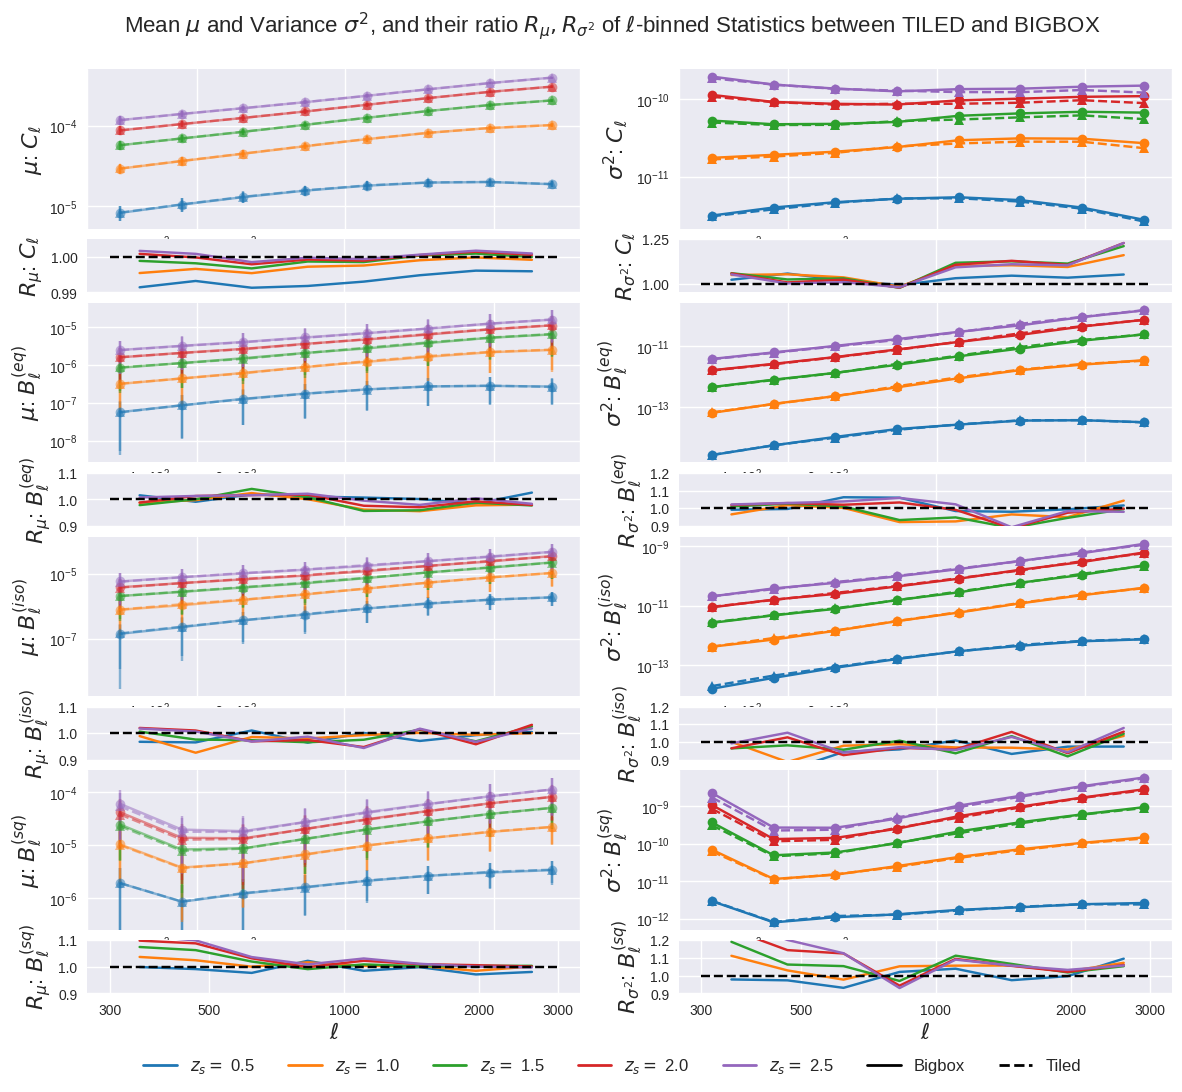

In [147]:
fig = plt.figure(figsize=(14, 3 * len(labels_ell)))

fig.suptitle("Mean $\mu$ and Variance $\sigma^2$, and their ratio $R_{\mu}, R_{\sigma^2}$ of $\ell$-binned Statistics between TILED and BIGBOX", fontsize=16, y=0.93)

gs_master = GridSpec(nrows=2 * len(labels_ell), ncols=1, height_ratios=[3, 1] * len(labels_ell), hspace=0.1)
gs_upper = [GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_master[i*2]) for i in range(len(labels_ell))]
gs_lower = [GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_master[i*2+1]) for i in range(len(labels_ell))]

ax_upper0 = [fig.add_subplot(gs_upper[i][0]) for i in range(len(labels_ell))]
ax_upper1 = [fig.add_subplot(gs_upper[i][1]) for i in range(len(labels_ell))]

ax_lower0 = [fig.add_subplot(gs_lower[i][0]) for i in range(len(labels_ell))]
ax_lower1 = [fig.add_subplot(gs_lower[i][1]) for i in range(len(labels_ell))]


for i, zs_i in enumerate(zs_list):
    zs = str(zs_i)
    for j, label in enumerate(labels_ell):
        # Check if data exists for both simulation types at this redshift
        if (('bigbox', zs_i) in means and (ngal, sl) in means[('bigbox', zs_i)] and
            ('tiled', zs_i) in means and (ngal, sl) in means[('tiled', zs_i)]):
            
            # Get data for the current statistic
            if label in means[('bigbox', zs_i)][(ngal, sl)] and label in means[('tiled', zs_i)][(ngal, sl)]:
                # Get means from both simulation types
                bigbox_mean = means[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_mean = means[('tiled', zs_i)][(ngal, sl)][label]
                
                # Get standard deviations 
                bigbox_std = stds[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_std = stds[('tiled', zs_i)][(ngal, sl)][label]
                
                # Get diagonal elements of covariance matrices
                if label in means[('bigbox', zs_i)][(ngal, sl)] and label in means[('tiled', zs_i)][(ngal, sl)]:
                    # Use variance (diagonal of covariance matrix)
                    bigbox_var = bigbox_std**2
                    tiled_var = tiled_std**2
                    
                    # Plot means with error bars in upper left panel
                    ax_upper0[j].errorbar(ell, bigbox_mean, yerr=bigbox_std, 
                            fmt='o', color=colors[i], alpha=0.5, linestyle='-')
                    ax_upper0[j].errorbar(ell, tiled_mean, yerr=tiled_std, 
                            fmt='^', color=colors[i], alpha=0.5, linestyle='--')
                    
                    # Plot variances in upper right panel
                    ax_upper1[j].plot(ell, bigbox_var, 
                            color=colors[i], marker='o', linestyle='-')
                    ax_upper1[j].plot(ell, tiled_var, 
                            color=colors[i], marker='^', linestyle='--')
                    
                    # Plot ratios in lower panels
                    ax_lower0[j].plot(ell, bigbox_mean/tiled_mean, color=colors[i])
                    ax_lower1[j].plot(ell, bigbox_var/tiled_var, color=colors[i])

for ax in ax_upper0 + ax_upper1:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(lmin, lmax)
    ax.set_xticks([300, 500, 1000, 2000, 3000])
    ax.set_xticklabels([])
    

for i, ax in enumerate(ax_lower0 + ax_lower1):
    ax.set_xscale("log")
    ax.hlines(1, lmin, lmax, color="black", linestyle="--")
    if i == len(labels_ell) - 1 or i == 2 * len(labels_ell) - 1:
        ax.set_xticks([300, 500, 1000, 2000, 3000])
        ax.set_xticklabels(["300", "500", "1000", "2000", "3000"])
        ax.set_xlabel(r"$\ell$", fontsize=fontsize)
    else:
        ax.tick_params(bottom=False, labelbottom=False)

for i, ax in enumerate(ax_lower0):
    ax.set_ylim(mranges_ell[i])

for i, ax in enumerate(ax_lower1):
    ax.set_ylim(vranges_ell[i])

for i, ax in enumerate(ax_upper0):
    ax.set_ylabel(f"$\mu$: {titles_ell[i % len(labels_ell)]}", fontsize=fontsize)

for i, ax in enumerate(ax_lower0):
    ax.set_ylabel(f"$R_\mu$: {titles_ell[i % len(labels_ell)]}", fontsize=fontsize)

for i, ax in enumerate(ax_upper1):
    ax.set_ylabel(f"$\sigma^2$: {titles_ell[i % len(labels_ell)]}", fontsize=fontsize)

for i, ax in enumerate(ax_lower1):
    ax.set_ylabel("$R_{\sigma^2}$: "+f"{titles_ell[i % len(labels_ell)]}", fontsize=fontsize)


custom_lines = [Line2D([0], [0], color=colors[i], lw=2) for i in range(len(zs_list))]
custom_lines2 = [Line2D([0], [0], linestyle=ls, lw=2, color="black") for ls in ["-", "--"]]

fig.legend(custom_lines + custom_lines2, [f"$z_s =$ {zs}" for zs in zs_list] + ["Bigbox", "Tiled"], bbox_to_anchor=(0.5, 0.07), loc='upper center', ncol=len(zs_list) + 2, fontsize=12)


fig.savefig(os.path.join(savedir, "ell_main.png"), bbox_inches="tight")

/var/tmp/pbs.414522.idark/ipykernel_251444/541713424.py:46: RuntimeWarning: invalid value encountered in true_divide
  ax_lower0[j].plot(nu, bigbox_mean/tiled_mean, color=colors[i])
/var/tmp/pbs.414522.idark/ipykernel_251444/541713424.py:47: RuntimeWarning: invalid value encountered in true_divide
  ax_lower1[j].plot(nu, bigbox_var/tiled_var, color=colors[i])
/var/tmp/pbs.414522.idark/ipykernel_251444/541713424.py:46: RuntimeWarning: divide by zero encountered in true_divide
  ax_lower0[j].plot(nu, bigbox_mean/tiled_mean, color=colors[i])
/var/tmp/pbs.414522.idark/ipykernel_251444/541713424.py:47: RuntimeWarning: divide by zero encountered in true_divide
  ax_lower1[j].plot(nu, bigbox_var/tiled_var, color=colors[i])


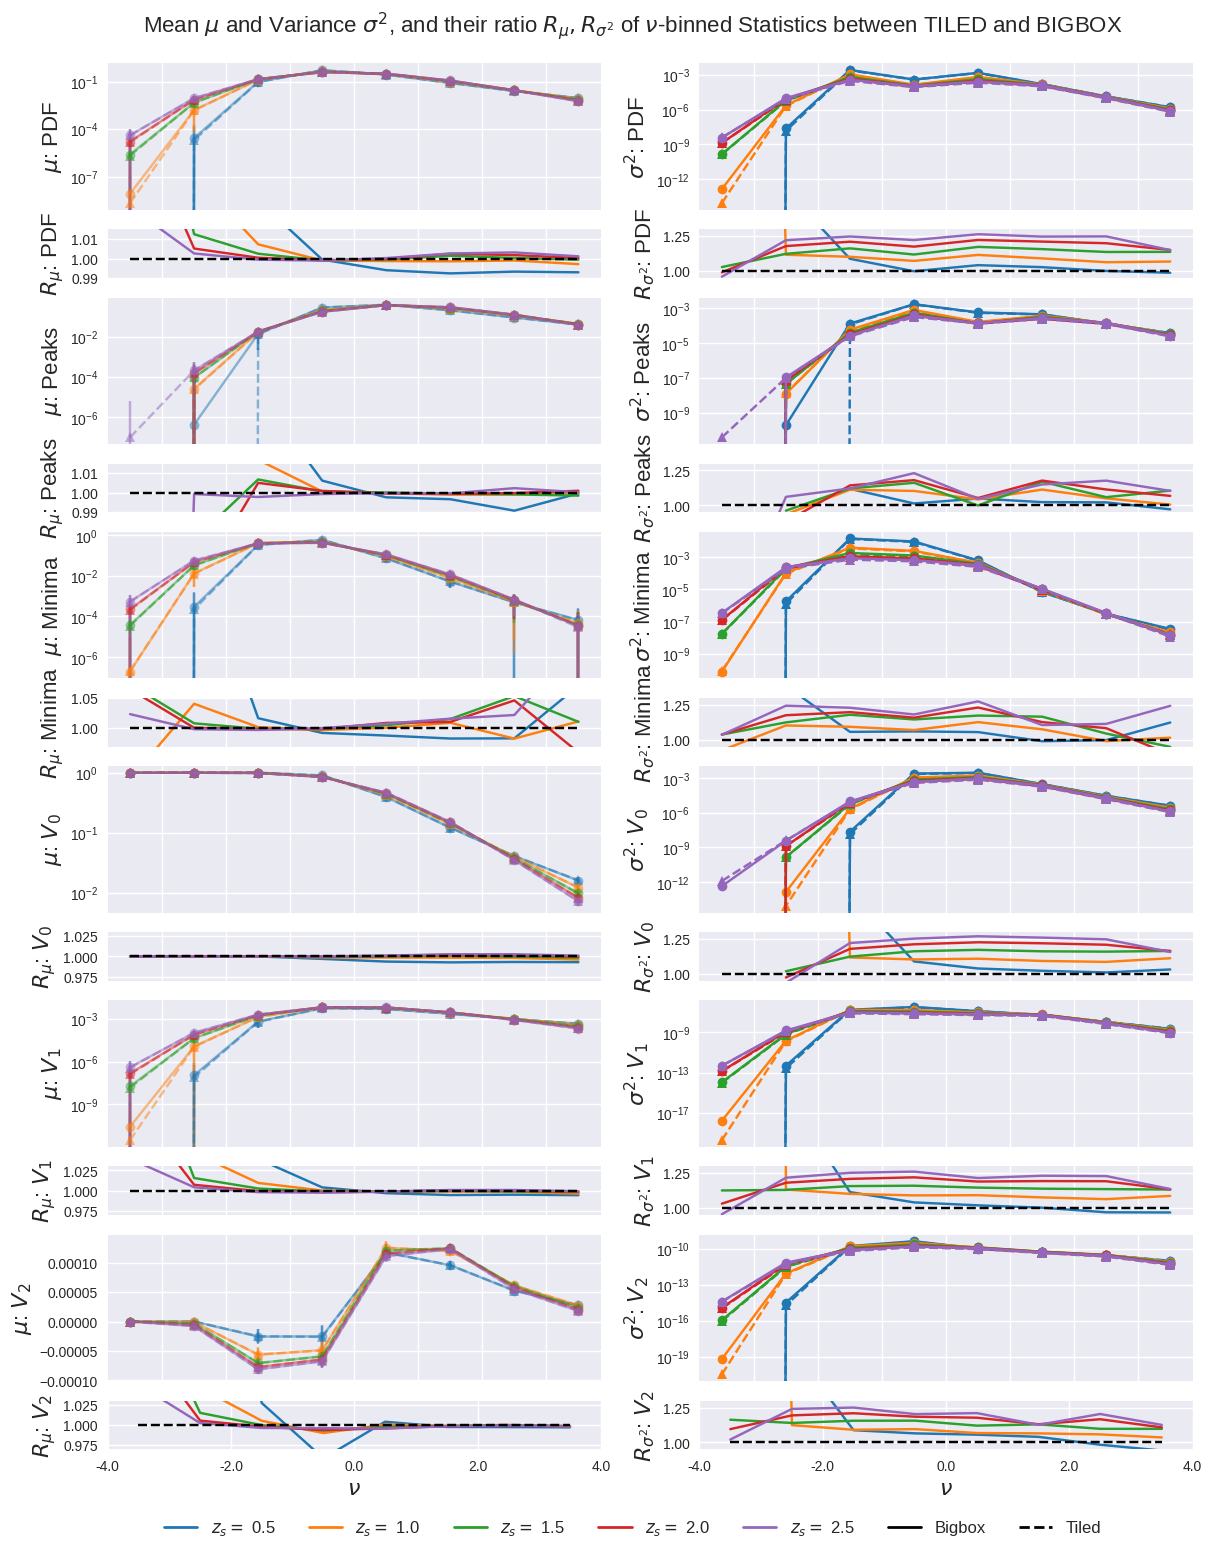

In [148]:
fig = plt.figure(figsize=(14, 3 * len(labels_nu)))

fig.suptitle(r"Mean $\mu$ and Variance $\sigma^2$, and their ratio $R_{\mu}, R_{\sigma^2}$ of ${\nu}$-binned Statistics between TILED and BIGBOX", fontsize=16, y=0.91)

gs_master = GridSpec(nrows=2 * len(labels_nu), ncols=1, height_ratios=[3, 1] * len(labels_nu), hspace=0.2)
gs_upper = [GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_master[i*2]) for i in range(len(labels_nu))]
gs_lower = [GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_master[i*2+1]) for i in range(len(labels_nu))]

ax_upper0 = [fig.add_subplot(gs_upper[i][0]) for i in range(len(labels_nu))]
ax_upper1 = [fig.add_subplot(gs_upper[i][1]) for i in range(len(labels_nu))]

ax_lower0 = [fig.add_subplot(gs_lower[i][0]) for i in range(len(labels_nu))]
ax_lower1 = [fig.add_subplot(gs_lower[i][1]) for i in range(len(labels_nu))]

for i, zs_i in enumerate(zs_list):
    zs = str(zs_i)
    for j, label in enumerate(labels_nu):
        # Check if data exists for both simulation types at this redshift
        if (('bigbox', zs_i) in means and (ngal, sl) in means[('bigbox', zs_i)] and
            ('tiled', zs_i) in means and (ngal, sl) in means[('tiled', zs_i)]):
            
            # Get data for the current statistic
            if label in means[('bigbox', zs_i)][(ngal, sl)] and label in means[('tiled', zs_i)][(ngal, sl)]:
                # Get means from both simulation types
                bigbox_mean = means[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_mean = means[('tiled', zs_i)][(ngal, sl)][label]
                
                # Get standard deviations
                bigbox_std = stds[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_std = stds[('tiled', zs_i)][(ngal, sl)][label]
                
                # Get diagonal elements of covariance matrices (variances)
                bigbox_var = bigbox_std**2
                tiled_var = tiled_std**2
                
                ax_upper0[j].errorbar(nu, tiled_mean, yerr=tiled_std, 
                    fmt="^", color=colors[i], alpha=0.5, linestyle="--")
                ax_upper0[j].errorbar(nu, bigbox_mean, yerr=bigbox_std, 
                    fmt="o", color=colors[i], alpha=0.5, linestyle="-")
                
                ax_upper1[j].plot(nu, tiled_var, 
                    color=colors[i], marker="^", linestyle="--")
                ax_upper1[j].plot(nu, bigbox_var, 
                    color=colors[i], marker="o", linestyle="-")
                
                ax_lower0[j].plot(nu, bigbox_mean/tiled_mean, color=colors[i])
                ax_lower1[j].plot(nu, bigbox_var/tiled_var, color=colors[i])

for ax in ax_upper0 + ax_upper1:
    ax.set_xscale("linear")
    ax.set_xticklabels([])

for i, ax in enumerate(ax_lower0 + ax_lower1):
    ax.set_xscale("linear")
    ax.hlines(1, nu.min(), nu.max(), color="black", linestyle="--")
    if i == len(labels_nu) - 1 or i == 2 * len(labels_nu) - 1:
        ax.set_xticks([-4, -2, 0, 2, 4])
        ax.set_xticklabels([f"{n:.1f}" for n in [-4, -2, 0, 2, 4]])
        ax.set_xlabel(r"$\nu$", fontsize=fontsize)
    else:
        ax.tick_params(bottom=False, labelbottom=False)

for i, ax in enumerate(ax_lower0):
    ax.set_ylim(mranges_nu[i])

for i, ax in enumerate(ax_lower1):
    ax.set_ylim(vranges_nu[i])

for i, ax in enumerate(ax_upper0):
    ax.set_ylabel(f"$\mu$: {titles_nu[i % len(labels_nu)]}", fontsize=fontsize)
    if i != len(labels_nu) - 1:
        ax.set_yscale("log")

for i, ax in enumerate(ax_lower0):
    ax.set_ylabel(f"$R_\mu$: {titles_nu[i % len(labels_nu)]}", fontsize=fontsize)

for i, ax in enumerate(ax_upper1):
    ax.set_ylabel(f"$\sigma^2$: {titles_nu[i % len(labels_nu)]}", fontsize=fontsize)
    ax.set_yscale("log")

for i, ax in enumerate(ax_lower1):
    ax.set_ylabel("$R_{\sigma^2}$: "+f"{titles_nu[i % len(labels_nu)]}", fontsize=fontsize)

custom_lines = [Line2D([0], [0], color=colors[i], lw=2) for i in range(len(zs_list))]
custom_lines2 = [Line2D([0], [0], linestyle=ls, lw=2, color="black") for ls in ["-", "--"]]

fig.legend(custom_lines + custom_lines2, [f"$z_s =$ {zs}" for zs in zs_list] + ["Bigbox", "Tiled"], bbox_to_anchor=(0.5, 0.08), loc='upper center', ncol=len(zs_list) + 2, fontsize=12)

fig.savefig(os.path.join(savedir, "nu_main.png"), bbox_inches="tight")

In [149]:
def cal_corr_avg(corr):
    # Exclude diagonal and NaN values, then calculate the average
    mask = ~np.eye(corr.shape[0], dtype=bool) & ~np.isnan(corr)
    return np.nanmean(corr[mask])

def safe_mean(arr):
    # infとマイナスinfをnanに置き換え
    arr_no_inf = np.where(np.isinf(arr), np.nan, arr)
    return np.nanmean(arr_no_inf)

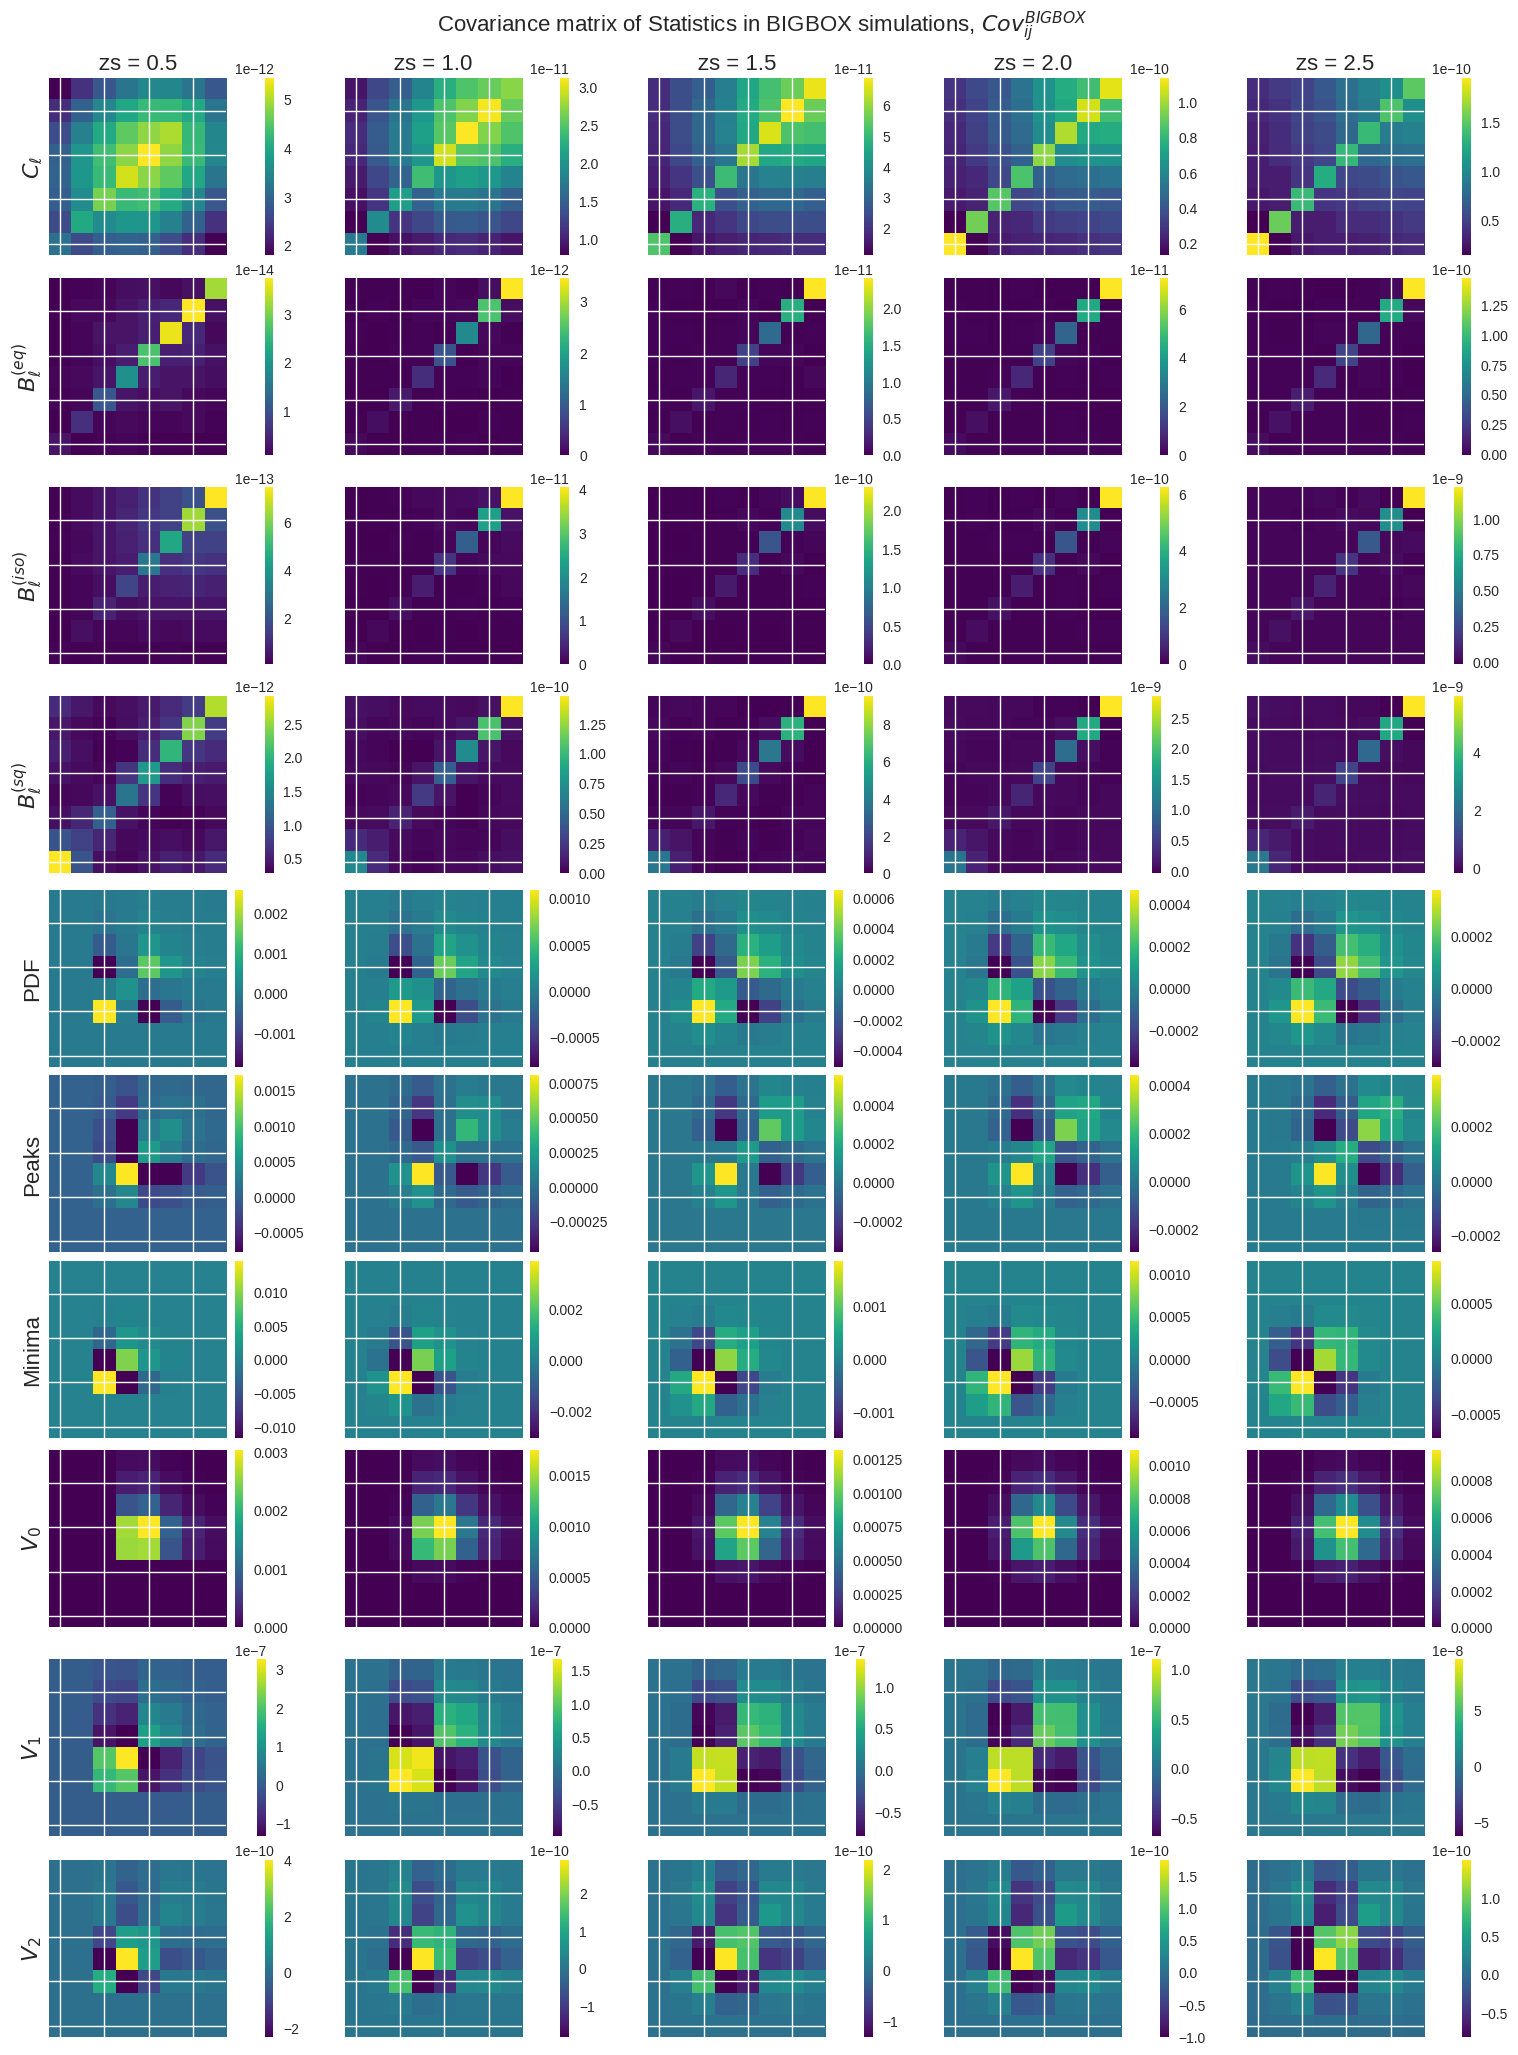

In [150]:
cmap = plt.get_cmap("viridis")
cmap.set_bad(color="gray")

cbarrange = []
# Assuming you have defined zs_list, labels_ell, labels_nu, titles_ell, titles_nu, stats_tiled, ngal, sl, cmap, and cbarrange

fig, ax = plt.subplots(
    len(labels_ell) + len(labels_nu),
    len(zs_list),
    figsize=(3 * len(zs_list), 2 * (len(labels_ell) + len(labels_nu))),
    constrained_layout=True
)

# add a main title
fig.suptitle(r"Covariance matrix of Statistics in BIGBOX simulations, $Cov_{ij}^{BIGBOX}$", fontsize=16, y=1.02)

for i, zs_i in enumerate(zs_list):
    zs = str(zs_i)
    
    # Process for ell-binned statistics (power spectrum, bispectra)
    for j, label in enumerate(labels_ell):
        if (('bigbox', zs_i) in covariances and 
            (ngal, sl) in covariances[('bigbox', zs_i)] and 
            label in covariances[('bigbox', zs_i)][(ngal, sl)]):
            
            # Get the covariance matrix for this statistic
            cov_matrix = covariances[('bigbox', zs_i)][(ngal, sl)][label]
            
            # Plot the covariance matrix
            im = ax[j, i].imshow(cov_matrix, cmap=cmap, origin="lower")
            fig.colorbar(im, ax=ax[j, i], fraction=0.046, pad=0.04)
            cbarrange.append(im.get_clim())
            
            # Set title only for the top row
            if j == 0:
                ax[j, i].set_title(f"zs = {zs_i}", fontsize=16)
            
            # Set y-axis label only for the first column
            if i == 0:
                ax[j, i].set_ylabel(titles_ell[j], fontsize=16)
            
            # Hide ticks
            ax[j, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            
            # Hide spines for a cleaner look
            for spine in ax[j, i].spines.values():
                spine.set_visible(False)
    
    # Process for nu-binned statistics (PDF, peaks, minima, Minkowski functionals)
    for j, label in enumerate(labels_nu):
        row_index = j + len(labels_ell)
        
        if (('bigbox', zs_i) in covariances and 
            (ngal, sl) in covariances[('bigbox', zs_i)] and 
            label in covariances[('bigbox', zs_i)][(ngal, sl)]):
            
            # Get the covariance matrix for this statistic
            cov_matrix = covariances[('bigbox', zs_i)][(ngal, sl)][label]
            
            # Plot the covariance matrix
            im = ax[row_index, i].imshow(cov_matrix, cmap=cmap, origin="lower")
            fig.colorbar(im, ax=ax[row_index, i], fraction=0.046, pad=0.04)
            cbarrange.append(im.get_clim())
            
            # Set y-axis label only for the first column
            if i == 0:
                ax[row_index, i].set_ylabel(titles_nu[j], fontsize=16)
            
            # Hide ticks
            ax[row_index, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            
            # Hide spines for a cleaner look
            for spine in ax[row_index, i].spines.values():
                spine.set_visible(False)

# Optional: Adjust layout, add a main title, etc.
fig.savefig(os.path.join(savedir, "cov_bigbox.png"), bbox_inches="tight")

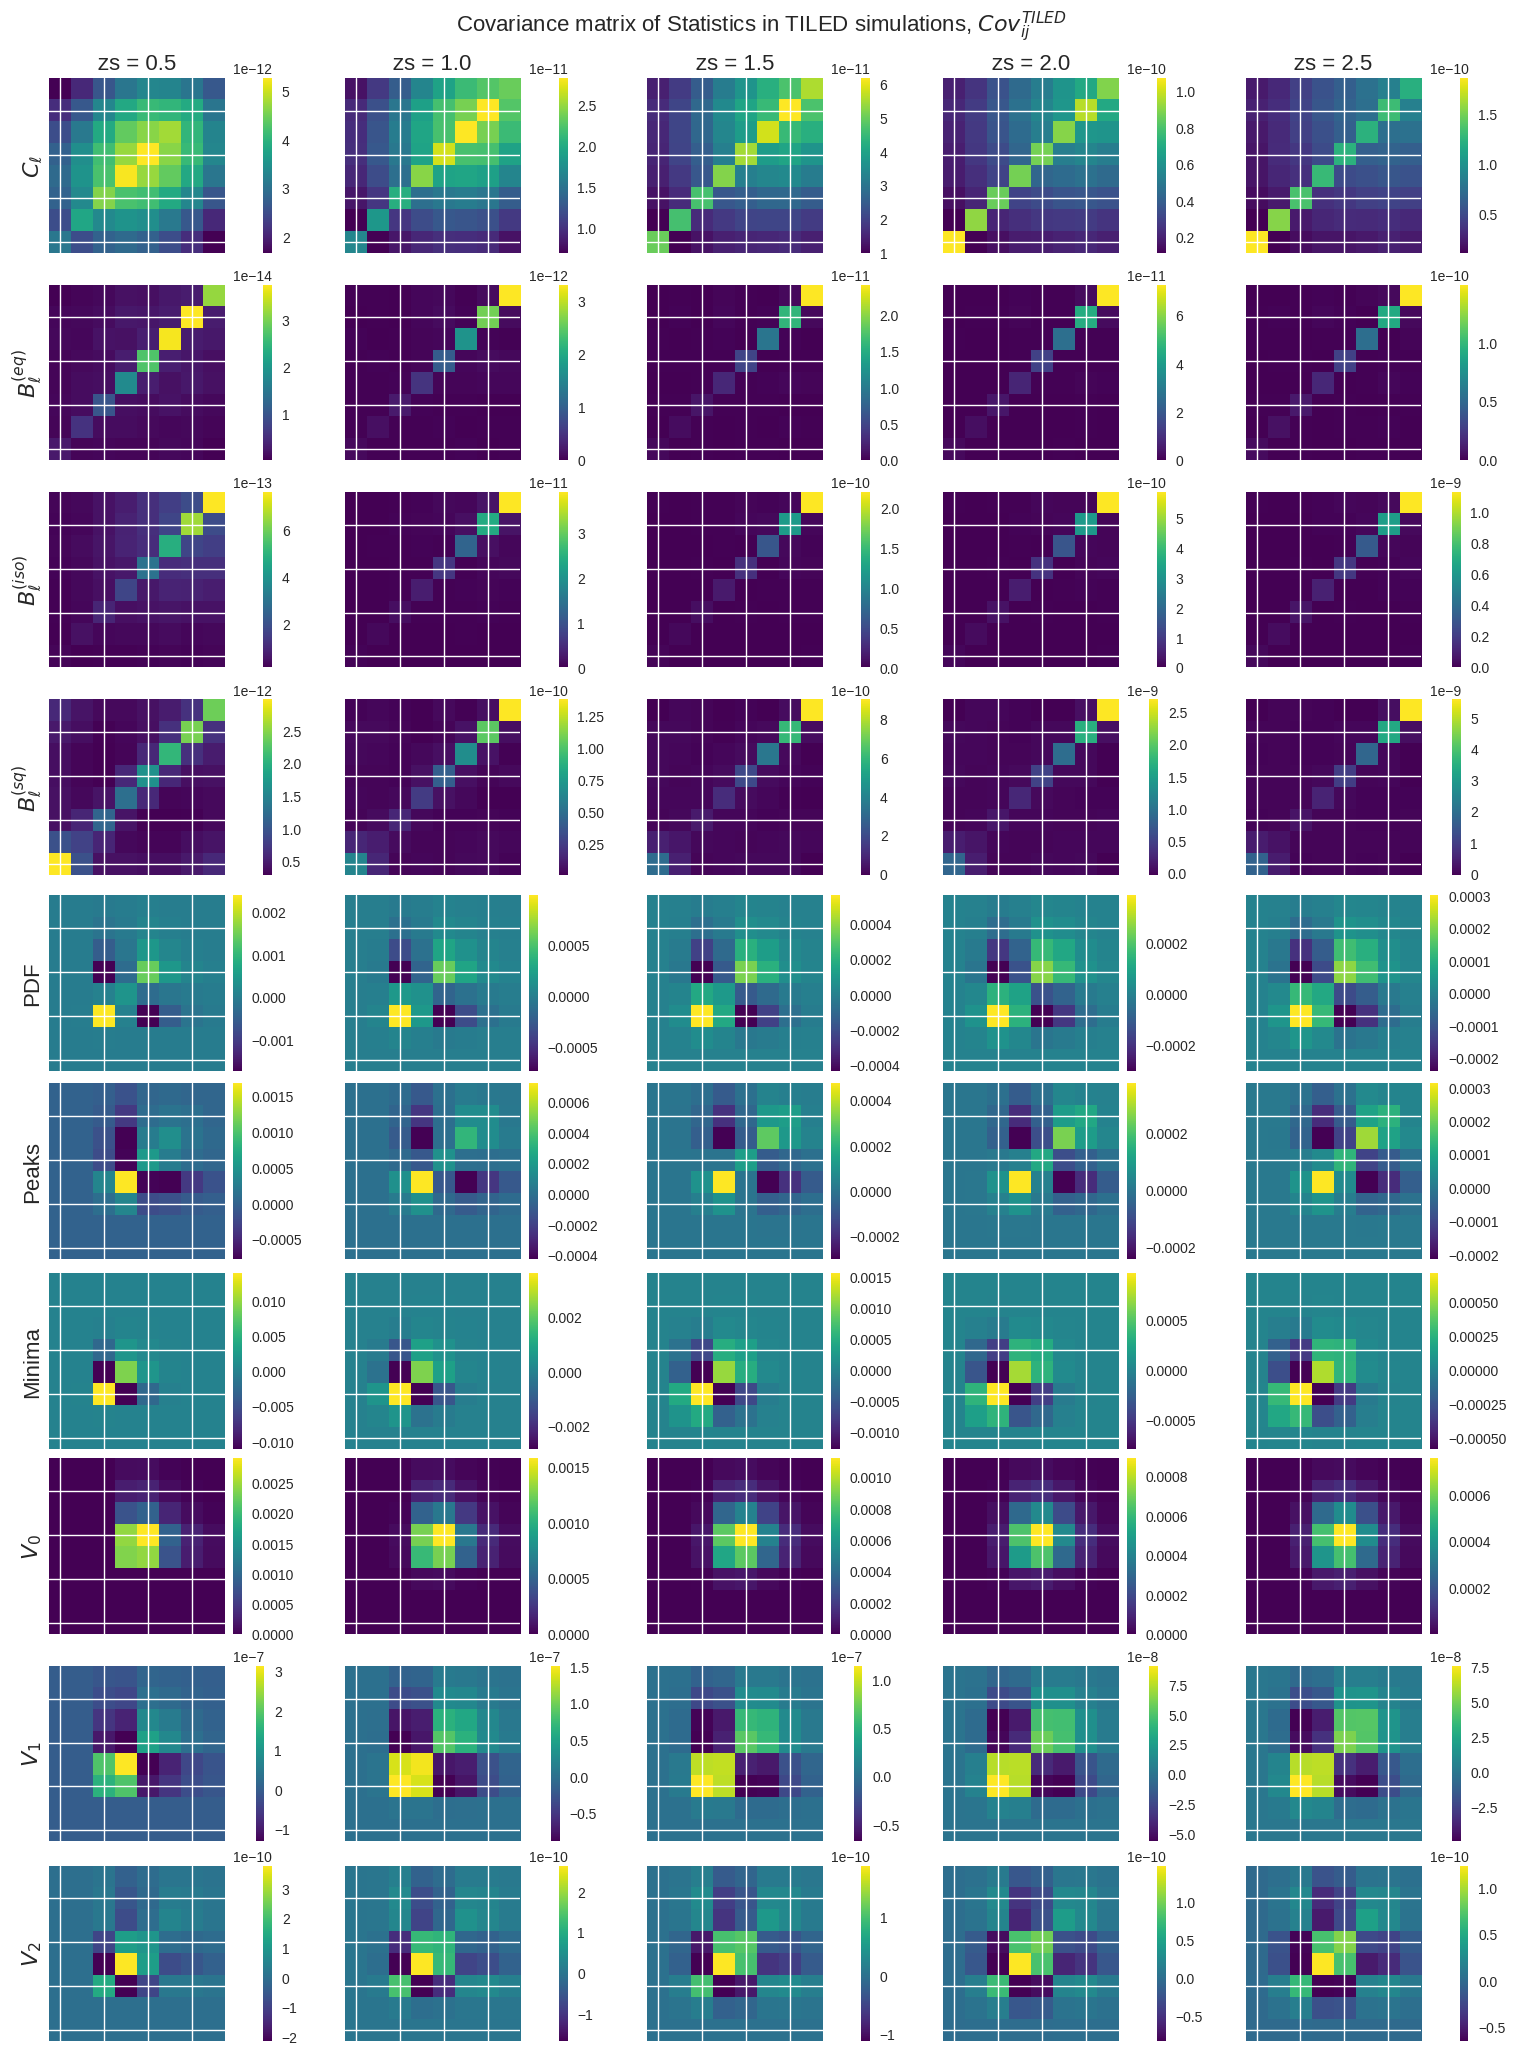

In [151]:
cmap = plt.get_cmap("viridis")
cmap.set_bad(color="gray")

cbarrange = []

fig, ax = plt.subplots(
    len(labels_ell) + len(labels_nu),
    len(zs_list),
    figsize=(3 * len(zs_list), 2 * (len(labels_ell) + len(labels_nu))),
    constrained_layout=True
)

# add a main title
fig.suptitle(r"Covariance matrix of Statistics in TILED simulations, $Cov_{ij}^{TILED}$", fontsize=16, y=1.02)

for i, zs_i in enumerate(zs_list):
    zs = str(zs_i)
    
    # Process for ell-binned statistics (power spectrum, bispectra)
    for j, label in enumerate(labels_ell):
        if (('tiled', zs_i) in covariances and 
            (ngal, sl) in covariances[('tiled', zs_i)] and 
            label in covariances[('tiled', zs_i)][(ngal, sl)]):
            
            # Get the covariance matrix for this statistic
            cov_matrix = covariances[('tiled', zs_i)][(ngal, sl)][label]
            
            # Plot the covariance matrix
            im = ax[j, i].imshow(cov_matrix, cmap=cmap, origin="lower")
            fig.colorbar(im, ax=ax[j, i], fraction=0.046, pad=0.04)
            cbarrange.append(im.get_clim())
            
            # Set title only for the top row
            if j == 0:
                ax[j, i].set_title(f"zs = {zs_i}", fontsize=16)
            
            # Set y-axis label only for the first column
            if i == 0:
                ax[j, i].set_ylabel(titles_ell[j], fontsize=16)
            
            # Hide ticks
            ax[j, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            
            # Hide spines for a cleaner look
            for spine in ax[j, i].spines.values():
                spine.set_visible(False)
    
    # Process for nu-binned statistics (PDF, peaks, minima, Minkowski functionals)
    for j, label in enumerate(labels_nu):
        row_index = j + len(labels_ell)
        
        if (('tiled', zs_i) in covariances and 
            (ngal, sl) in covariances[('tiled', zs_i)] and 
            label in covariances[('tiled', zs_i)][(ngal, sl)]):
            
            # Get the covariance matrix for this statistic
            cov_matrix = covariances[('tiled', zs_i)][(ngal, sl)][label]
            
            # Plot the covariance matrix
            im = ax[row_index, i].imshow(cov_matrix, cmap=cmap, origin="lower")
            fig.colorbar(im, ax=ax[row_index, i], fraction=0.046, pad=0.04)
            cbarrange.append(im.get_clim())
            
            # Set y-axis label only for the first column
            if i == 0:
                ax[row_index, i].set_ylabel(titles_nu[j], fontsize=16)
            
            # Hide ticks
            ax[row_index, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            
            # Hide spines for a cleaner look
            for spine in ax[row_index, i].spines.values():
                spine.set_visible(False)

# Save the figure
fig.savefig(os.path.join(savedir, "cov_tiled.png"), bbox_inches="tight")


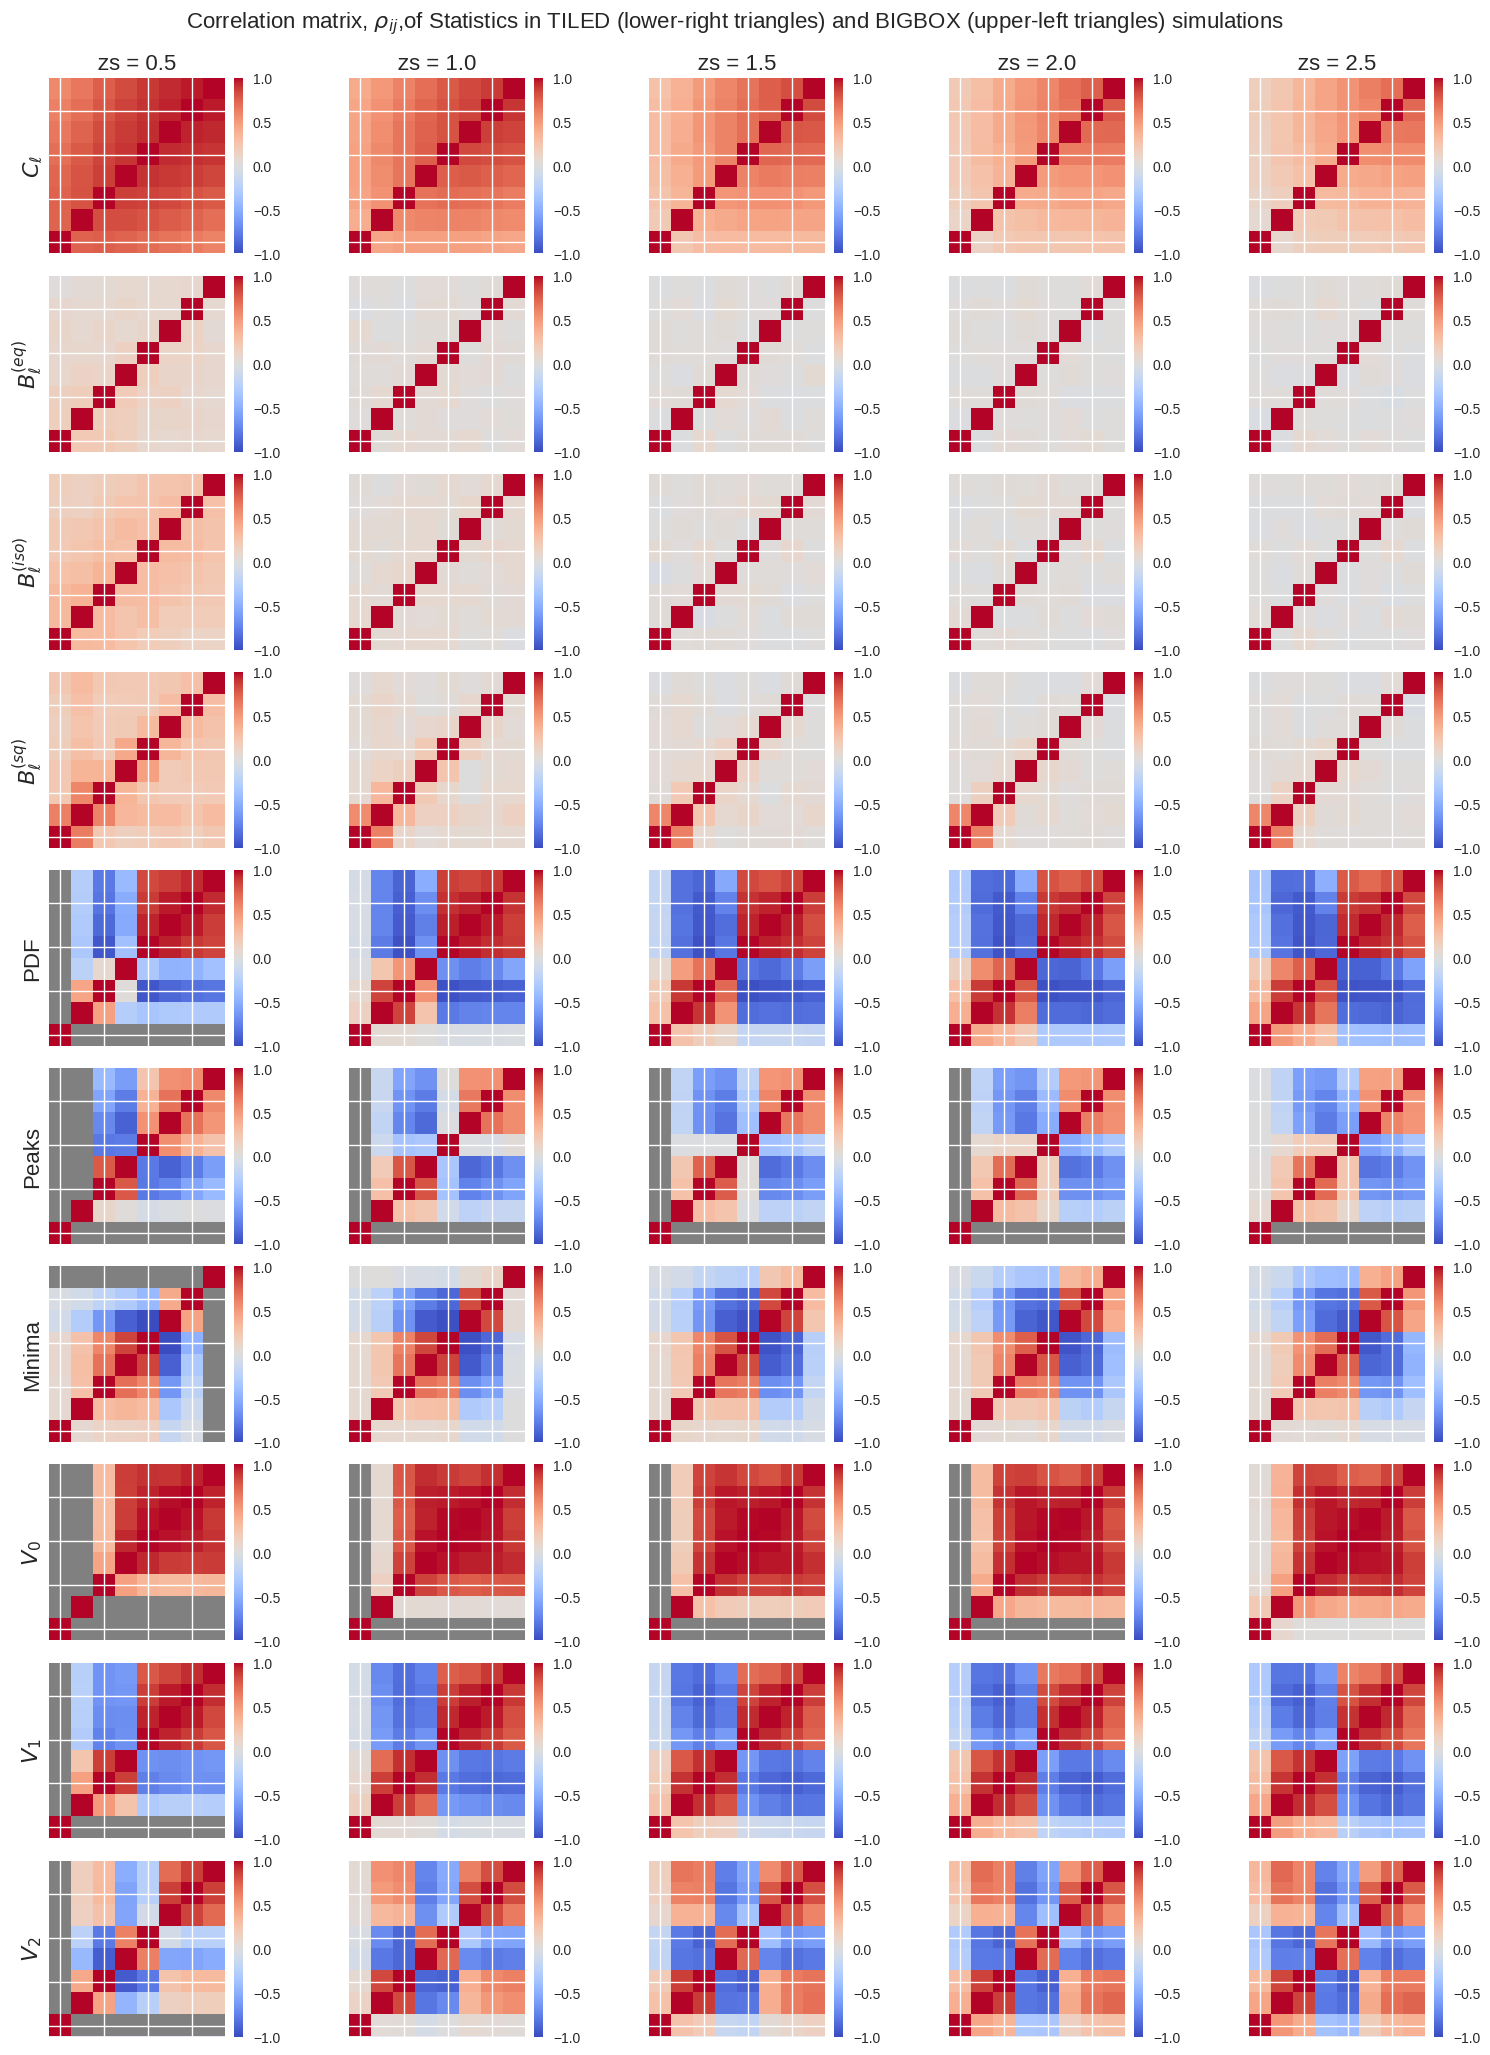

In [152]:
cmap = plt.get_cmap("coolwarm")
cmap.set_bad(color="gray")

def merge_corr(corr1, corr2):
    if corr1.shape != corr2.shape or corr1.ndim != 2 or corr1.shape[0] != corr1.shape[1]:
        raise ValueError("Both correlation matrices must be square and have the same shape.")
    
    merged_corr = np.zeros_like(corr1)
    upper_indices = np.triu_indices_from(corr1, k=1)
    lower_indices = np.tril_indices_from(corr1, k=-1)
    
    merged_corr[upper_indices] = corr1[upper_indices]
    merged_corr[lower_indices] = corr2[lower_indices]
    np.fill_diagonal(merged_corr, 1.0)
    
    return merged_corr


crange = (0.7, 1.3)
# Assuming you have defined zs_list, labels_ell, labels_nu, titles_ell, titles_nu, stats_tiled, ngal, sl, cmap, and cbarrange

fig, ax = plt.subplots(
    len(labels_ell) + len(labels_nu),
    len(zs_list),
    figsize=(3 * len(zs_list), 2 * (len(labels_ell) + len(labels_nu))),
    constrained_layout=True
)

# add a main title
fig.suptitle(r"Correlation matrix, $\rho_{ij}$,of Statistics in TILED (lower-right triangles) and BIGBOX (upper-left triangles) simulations", fontsize=16, y=1.02)

for i, zs_i in enumerate(zs_list):
    for j, label in enumerate(labels_ell):
        # Check if data exists for both simulation types at this redshift
        if (('bigbox', zs_i) in correlations and 
            (ngal, sl) in correlations[('bigbox', zs_i)] and 
            ('tiled', zs_i) in correlations and 
            (ngal, sl) in correlations[('tiled', zs_i)]):
            
            if label in correlations[('bigbox', zs_i)][(ngal, sl)] and label in correlations[('tiled', zs_i)][(ngal, sl)]:
                # Create merged correlation matrix
                bigbox_corr = correlations[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_corr = correlations[('tiled', zs_i)][(ngal, sl)][label]
                
                # Merge correlations - bigbox in upper triangle, tiled in lower triangle
                tmp_corr = merge_corr(bigbox_corr, tiled_corr)
                
                # Plot the merged correlation matrix
                im = ax[j, i].imshow(tmp_corr, cmap=cmap, origin="lower", vmin=-1, vmax=1)
                fig.colorbar(im, ax=ax[j, i], fraction=0.046, pad=0.04)
                
                # Set title only for the top row
                if j == 0:
                    ax[j, i].set_title(f"zs = {zs_i}", fontsize=16)
                
                # Set y-axis label only for the first column
                if i == 0:
                    ax[j, i].set_ylabel(titles_ell[j], fontsize=16)
                
                # Hide ticks
                ax[j, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
                
                # Hide spines for a cleaner look
                for spine in ax[j, i].spines.values():
                    spine.set_visible(False)
    
    # Process for nu-binned statistics
    for j, label in enumerate(labels_nu):
        row_index = j + len(labels_ell)
        
        # Check if data exists for both simulation types at this redshift
        if (('bigbox', zs_i) in correlations and 
            (ngal, sl) in correlations[('bigbox', zs_i)] and 
            ('tiled', zs_i) in correlations and 
            (ngal, sl) in correlations[('tiled', zs_i)]):
            
            if label in correlations[('bigbox', zs_i)][(ngal, sl)] and label in correlations[('tiled', zs_i)][(ngal, sl)]:
                # Create merged correlation matrix
                bigbox_corr = correlations[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_corr = correlations[('tiled', zs_i)][(ngal, sl)][label]
                
                # For minima, reverse the matrices if needed to match expected orientation
                if label == "minima":
                    tmp_corr = merge_corr(bigbox_corr[::-1, ::-1], tiled_corr[::-1, ::-1])
                else:
                    tmp_corr = merge_corr(bigbox_corr, tiled_corr)
                
                # Plot the merged correlation matrix
                im = ax[row_index, i].imshow(tmp_corr, cmap=cmap, origin="lower", vmin=-1, vmax=1)
                fig.colorbar(im, ax=ax[row_index, i], fraction=0.046, pad=0.04)
                
                # Set y-axis label only for the first column
                if i == 0:
                    ax[row_index, i].set_ylabel(titles_nu[j], fontsize=16)
                
                # Hide ticks
                ax[row_index, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
                
                # Hide spines for a cleaner look
                for spine in ax[row_index, i].spines.values():
                    spine.set_visible(False)

# Optional: Adjust layout, add a main title, etc.
fig.savefig(os.path.join(savedir, "corr_main.png"), bbox_inches="tight")

/var/tmp/pbs.414522.idark/ipykernel_251444/3034512216.py:72: RuntimeWarning: invalid value encountered in true_divide
  bigbox_cov / tiled_cov,
/var/tmp/pbs.414522.idark/ipykernel_251444/3034512216.py:72: RuntimeWarning: divide by zero encountered in true_divide
  bigbox_cov / tiled_cov,


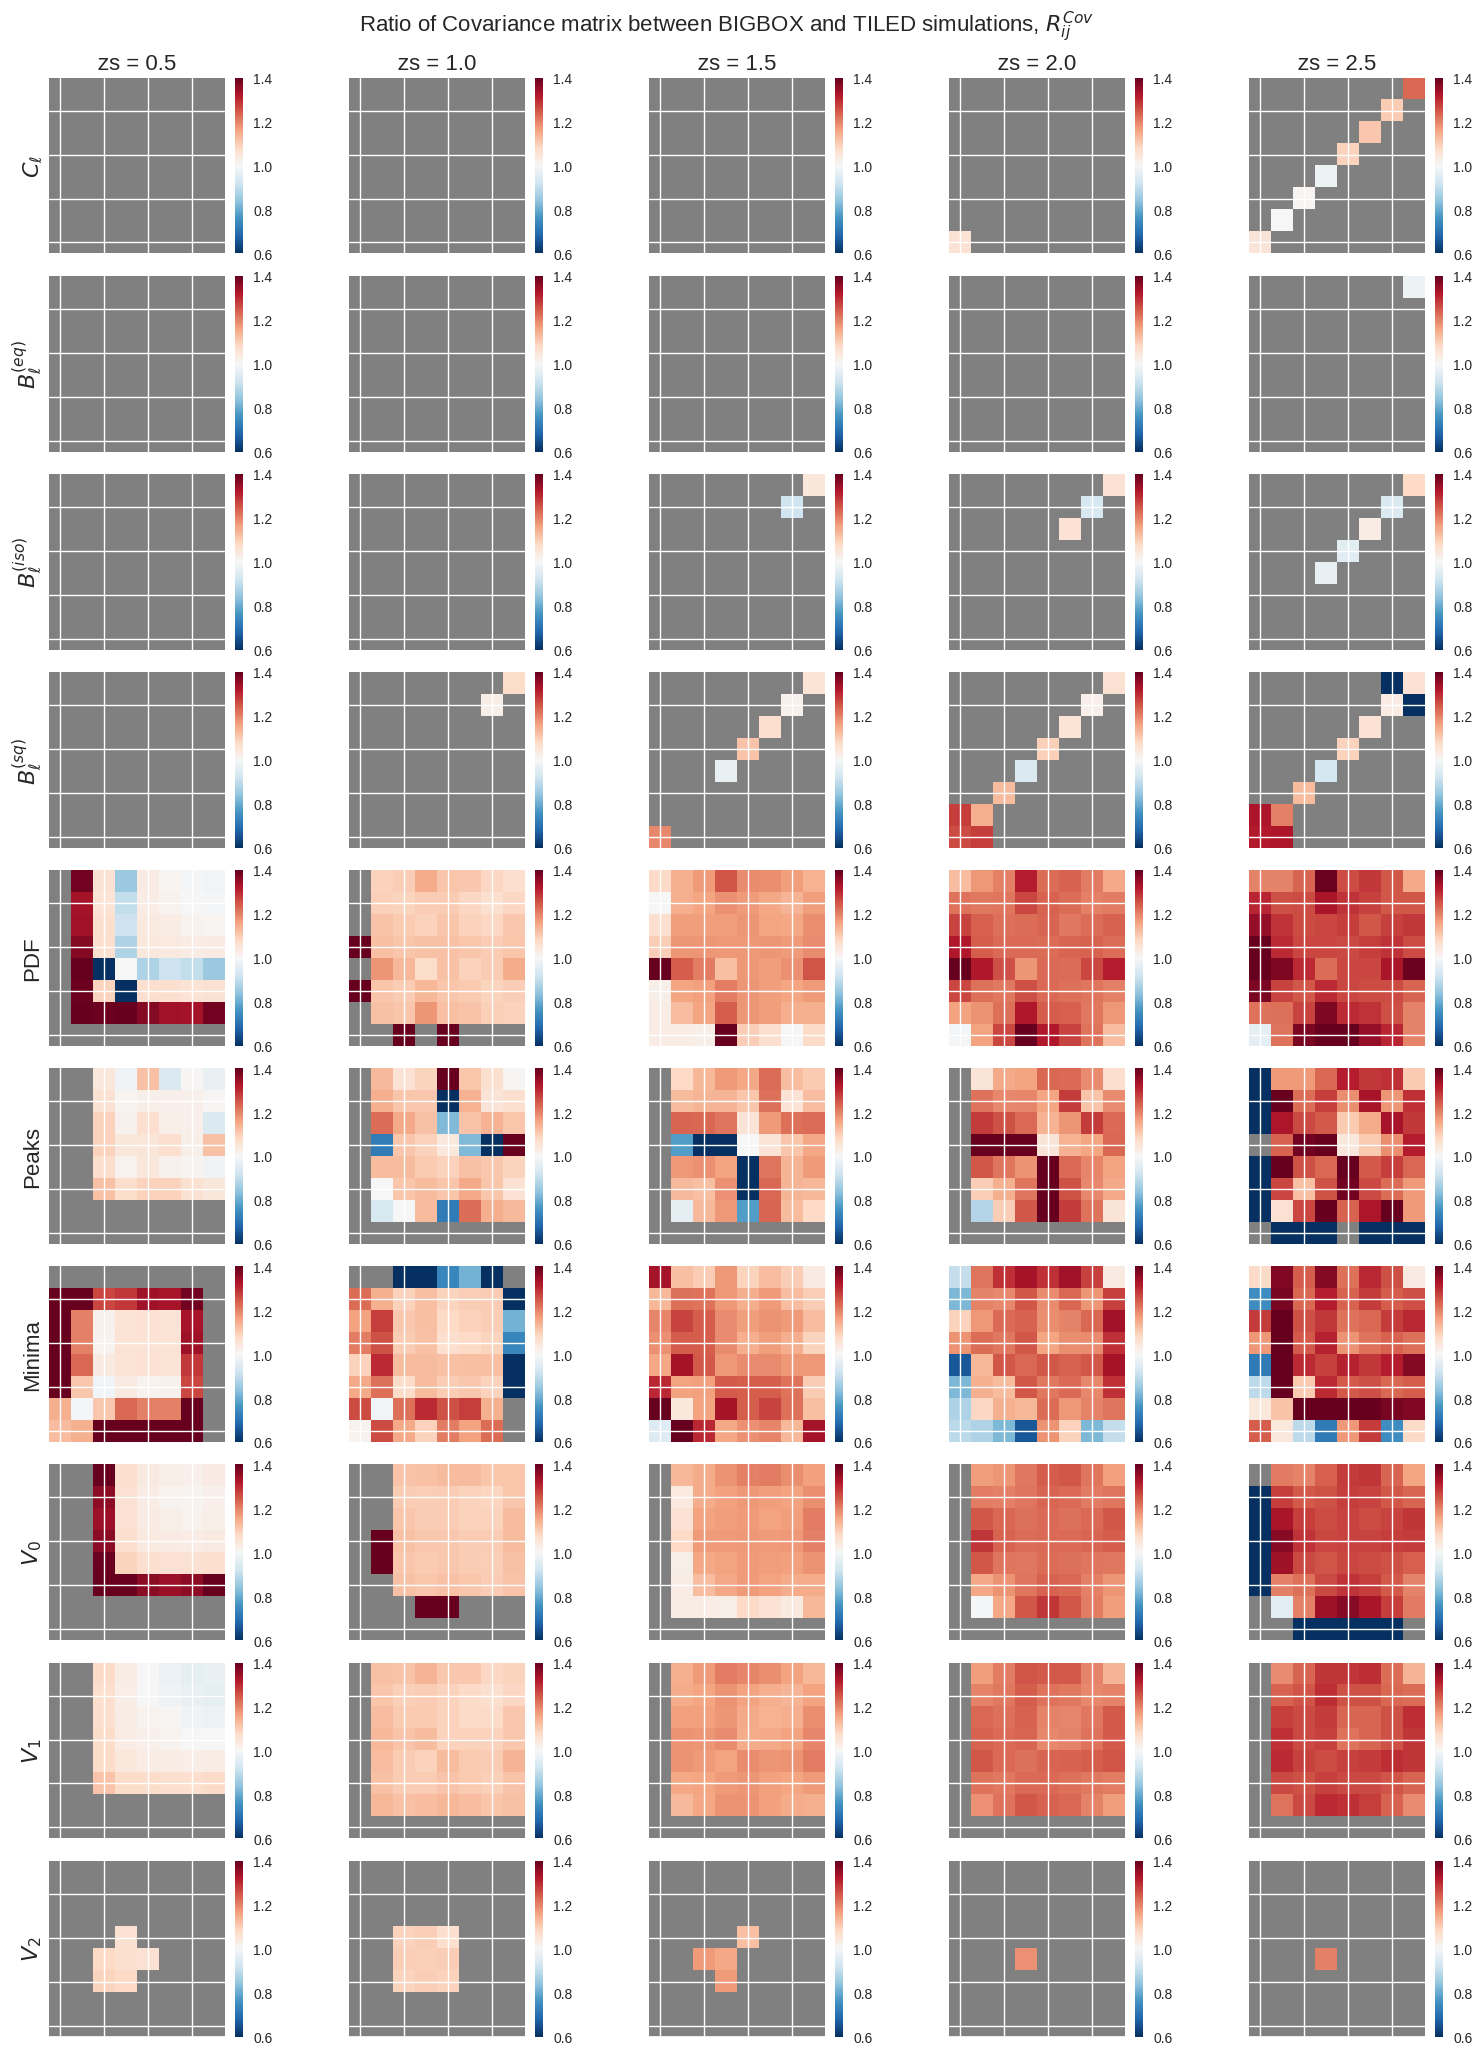

In [153]:
cmap = plt.get_cmap("RdBu_r")
cmap.set_bad(color="gray")

fig, ax = plt.subplots(
    len(labels_ell) + len(labels_nu),
    len(zs_list),
    figsize=(3 * len(zs_list), 2 * (len(labels_ell) + len(labels_nu))),
    constrained_layout=True
)

# add a main title
fig.suptitle(r"Ratio of Covariance matrix between BIGBOX and TILED simulations, $R^{Cov}_{ij}$", fontsize=16, y=1.02)

for i, zs_i in enumerate(zs_list):
    # Process for ell-binned statistics
    for j, label in enumerate(labels_ell):
        if (('bigbox', zs_i) in covariances and 
            (ngal, sl) in covariances[('bigbox', zs_i)] and 
            ('tiled', zs_i) in covariances and 
            (ngal, sl) in covariances[('tiled', zs_i)]):
            
            if label in covariances[('bigbox', zs_i)][(ngal, sl)] and label in covariances[('tiled', zs_i)][(ngal, sl)]:
                # Get covariance matrices for both simulation types
                bigbox_cov = covariances[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_cov = covariances[('tiled', zs_i)][(ngal, sl)][label]
                
                # Calculate ratio of covariances (avoid division by zero)
                ratio = np.where(np.abs(tiled_cov) > 1e-10, 
                                bigbox_cov / tiled_cov, 
                                np.nan)
                
                # Plot the ratio
                im = ax[j, i].imshow(ratio, cmap=cmap, origin="lower", vmin=0.6, vmax=1.4)
                fig.colorbar(im, ax=ax[j, i], fraction=0.046, pad=0.04)
                
                # Set title only for the top row
                if j == 0:
                    ax[j, i].set_title(f"zs = {zs_i}", fontsize=16)
                
                # Set y-axis label only for the first column
                if i == 0:
                    ax[j, i].set_ylabel(titles_ell[j], fontsize=16)
                
                # Hide ticks
                ax[j, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
                
                # Hide spines for a cleaner look
                for spine in ax[j, i].spines.values():
                    spine.set_visible(False)
    
    # Process for nu-binned statistics
    for j, label in enumerate(labels_nu):
        row_index = j + len(labels_ell)
        
        if (('bigbox', zs_i) in covariances and 
            (ngal, sl) in covariances[('bigbox', zs_i)] and 
            ('tiled', zs_i) in covariances and 
            (ngal, sl) in covariances[('tiled', zs_i)]):
            
            if label in covariances[('bigbox', zs_i)][(ngal, sl)] and label in covariances[('tiled', zs_i)][(ngal, sl)]:
                # Get covariance matrices for both simulation types
                bigbox_cov = covariances[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_cov = covariances[('tiled', zs_i)][(ngal, sl)][label]
                
                # Handle special case for minima (reverse matrices if needed)
                if label == "minima":
                    bigbox_cov = bigbox_cov[::-1, ::-1]
                    tiled_cov = tiled_cov[::-1, ::-1]
                
                # Calculate ratio of covariances (avoid division by zero)
                ratio = np.where(np.abs(tiled_cov) > 1e-10, 
                                bigbox_cov / tiled_cov, 
                                np.nan)
                
                # Plot the ratio
                im = ax[row_index, i].imshow(ratio, cmap=cmap, origin="lower", vmin=0.6, vmax=1.4)
                fig.colorbar(im, ax=ax[row_index, i], fraction=0.046, pad=0.04)
                
                # Set y-axis label only for the first column
                if i == 0:
                    ax[row_index, i].set_ylabel(titles_nu[j], fontsize=16)
                
                # Hide ticks
                ax[row_index, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
                
                # Hide spines for a cleaner look
                for spine in ax[row_index, i].spines.values():
                    spine.set_visible(False)

# Save the figure
fig.savefig(os.path.join(savedir, "cov_ratio.png"), bbox_inches="tight")

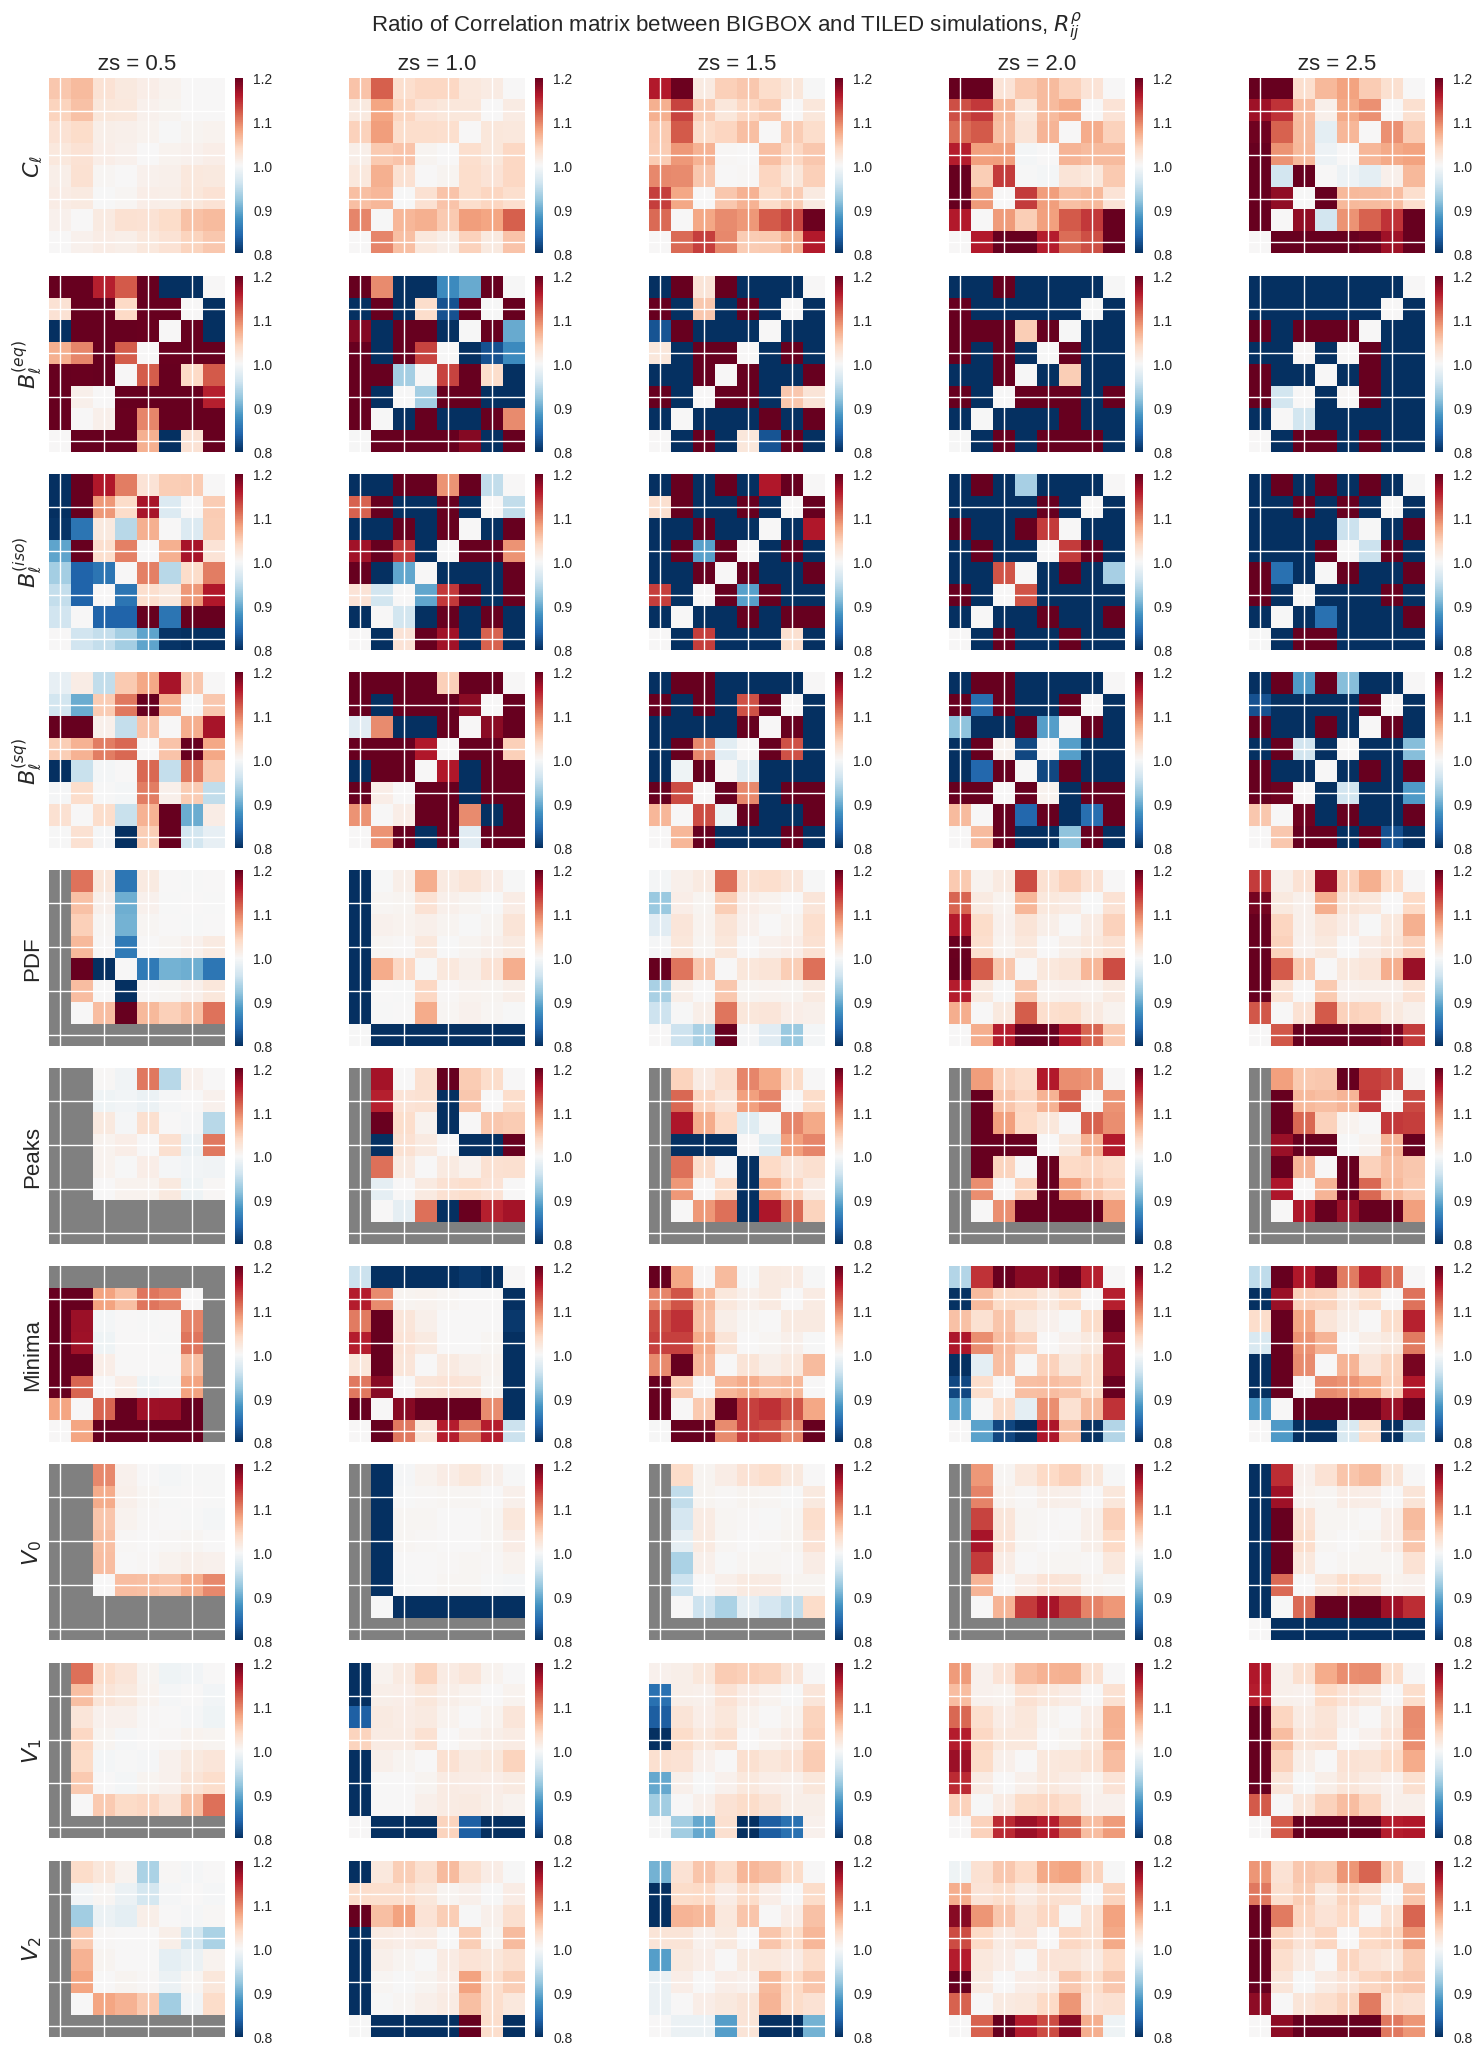

In [154]:
cmap = plt.get_cmap("RdBu_r")
cmap.set_bad(color="gray")

fig, ax = plt.subplots(
    len(labels_ell) + len(labels_nu),
    len(zs_list),
    figsize=(3 * len(zs_list), 2 * (len(labels_ell) + len(labels_nu))),
    constrained_layout=True
)

# add a main title
fig.suptitle(r"Ratio of Correlation matrix between BIGBOX and TILED simulations, $R_{ij}^{\rho}$", fontsize=16, y=1.02)

for i, zs_i in enumerate(zs_list):
    # Process for ell-binned statistics
    for j, label in enumerate(labels_ell):
        if (('bigbox', zs_i) in correlations and 
            (ngal, sl) in correlations[('bigbox', zs_i)] and 
            ('tiled', zs_i) in correlations and 
            (ngal, sl) in correlations[('tiled', zs_i)]):
            
            if label in correlations[('bigbox', zs_i)][(ngal, sl)] and label in correlations[('tiled', zs_i)][(ngal, sl)]:
                # Get correlation matrices for both simulation types
                bigbox_corr = correlations[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_corr = correlations[('tiled', zs_i)][(ngal, sl)][label]
                
                # Calculate ratio (avoid division by zero)
                ratio = np.where(np.abs(tiled_corr) > 1e-10, 
                                bigbox_corr / tiled_corr, 
                                np.nan)
                
                # Plot the ratio
                im = ax[j, i].imshow(ratio, cmap=cmap, origin="lower", vmin=0.8, vmax=1.2)
                fig.colorbar(im, ax=ax[j, i], fraction=0.046, pad=0.04)
                
                # Set title only for the top row
                if j == 0:
                    ax[j, i].set_title(f"zs = {zs_i}", fontsize=16)
                
                # Set y-axis label only for the first column
                if i == 0:
                    ax[j, i].set_ylabel(titles_ell[j], fontsize=16)
                
                # Hide ticks
                ax[j, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
                
                # Hide spines for a cleaner look
                for spine in ax[j, i].spines.values():
                    spine.set_visible(False)
    
    # Process for nu-binned statistics
    for j, label in enumerate(labels_nu):
        row_index = j + len(labels_ell)
        
        if (('bigbox', zs_i) in correlations and 
            (ngal, sl) in correlations[('bigbox', zs_i)] and 
            ('tiled', zs_i) in correlations and 
            (ngal, sl) in correlations[('tiled', zs_i)]):
            
            if label in correlations[('bigbox', zs_i)][(ngal, sl)] and label in correlations[('tiled', zs_i)][(ngal, sl)]:
                # Get correlation matrices for both simulation types
                bigbox_corr = correlations[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_corr = correlations[('tiled', zs_i)][(ngal, sl)][label]
                
                # Handle special case for minima if needed
                if label == "minima":
                    bigbox_corr = bigbox_corr[::-1, ::-1]
                    tiled_corr = tiled_corr[::-1, ::-1]
                
                # Calculate ratio (avoid division by zero)
                ratio = np.where(np.abs(tiled_corr) > 1e-10, 
                                bigbox_corr / tiled_corr, 
                                np.nan)
                
                # Plot the ratio
                im = ax[row_index, i].imshow(ratio, cmap=cmap, origin="lower", vmin=0.8, vmax=1.2)
                fig.colorbar(im, ax=ax[row_index, i], fraction=0.046, pad=0.04)
                
                # Set y-axis label only for the first column
                if i == 0:
                    ax[row_index, i].set_ylabel(titles_nu[j], fontsize=16)
                
                # Hide ticks
                ax[row_index, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
                
                # Hide spines for a cleaner look
                for spine in ax[row_index, i].spines.values():
                    spine.set_visible(False)

# Save the figure
fig.savefig(os.path.join(savedir, "corr_ratio.png"), bbox_inches="tight")

In [155]:
labels = labels_ell[:1] + labels_nu
markers = [ "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "*", "h", "H", "+", "x", "D"]
colors= ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

survey_info = {
    '0': 'Noiseless',
    '7': 'DES',
    '15': 'HSC',
    '30': 'LSST',
    '50': 'Roman'
}

In [170]:
labels

['power_spectra', 'pdf', 'peaks', 'minima', 'v0', 'v1', 'v2']

In [176]:
(ngal, sl) in covariances[('bigbox', zs_i)]

False

In [178]:

sl = "sl_2"

# Initialize dictionaries to store average ratios
avgs_cov = {}
avgs_corr = {}

# Number of bins for each statistic (used for excluding edge bins)
nbin = len(nu)
except_indices=[(1, nbin-1), (1, nbin-1), (1, nbin-1), (1, nbin-1), (1, nbin-1), (1, nbin-1)]

# Process for each noise level
for ngal_i in ngal_list:
    ngal = f"ngal_{ngal_i}"
    avgs_cov[ngal] = {}
    avgs_corr[ngal] = {}
    
    # Process for each redshift
    for i, zs_i in enumerate(zs_list):
        # Process ell-binned statistics (power spectrum, bispectra)
        for label in labels_ell[:1]:  # Just power spectra
            # Initialize lists if not already done
            if label not in avgs_cov[ngal]:
                avgs_cov[ngal][label] = []
            if label not in avgs_corr[ngal]:
                avgs_corr[ngal][label] = []
            
            # Get covariance and correlation matrices
            if (('bigbox', zs_i) in covariances and (ngal, sl) in covariances[('bigbox', zs_i)] and
                ('tiled', zs_i) in covariances and (ngal, sl) in covariances[('tiled', zs_i)]):
                if label in covariances[('bigbox', zs_i)][(ngal, sl)] and label in covariances[('tiled', zs_i)][(ngal, sl)]:
                    # Calculate ratio of covariance matrices
                    cov_ratio = covariances[('bigbox', zs_i)][(ngal, sl)][label] / covariances[('tiled', zs_i)][(ngal, sl)][label]
                    # Calculate ratio of correlation matrices
                    corr_ratio = correlations[('bigbox', zs_i)][(ngal, sl)][label] / correlations[('tiled', zs_i)][(ngal, sl)][label]
                    # Calculate mean of ratio (excluding NaN and inf values)
                    avgs_cov[ngal][label].append(safe_mean(cov_ratio))
                    avgs_corr[ngal][label].append(cal_corr_avg(corr_ratio))
        
        # Process nu-binned statistics (PDF, peaks, minima, MFs)
        for j, label in enumerate(labels_nu):
            # Initialize lists if not already done
            if label not in avgs_cov[ngal]:
                avgs_cov[ngal][label] = []
            if label not in avgs_corr[ngal]:
                avgs_corr[ngal][label] = []
            
            # Define range of bins to use (exclude edges)
            rmin, rmax = except_indices[j]
            
            if (('bigbox', zs_i) in covariances and (ngal, sl) in covariances[('bigbox', zs_i)] and
                ('tiled', zs_i) in covariances and (ngal, sl) in covariances[('tiled', zs_i)]):
                if label in covariances[('bigbox', zs_i)][(ngal, sl)] and label in covariances[('tiled', zs_i)][(ngal, sl)]:
                    # Get covariance matrices
                    bigbox_cov = covariances[('bigbox', zs_i)][(ngal, sl)][label]
                    tiled_cov = covariances[('tiled', zs_i)][(ngal, sl)][label]
                    
                    # Get correlation matrices
                    bigbox_corr = correlations[('bigbox', zs_i)][(ngal, sl)][label]
                    tiled_corr = correlations[('tiled', zs_i)][(ngal, sl)][label]
                    
                    # Calculate ratios
                    cov_ratio = bigbox_cov / tiled_cov
                    corr_ratio = bigbox_corr / tiled_corr
                    
                    # Calculate means of ratios in the specified range
                    avgs_cov[ngal][label].append(safe_mean(cov_ratio[rmin:rmax, rmin:rmax]))
                    avgs_corr[ngal][label].append(cal_corr_avg(corr_ratio[rmin:rmax, rmin:rmax]))

/var/tmp/pbs.414522.idark/ipykernel_251444/642397261.py:62: RuntimeWarning: invalid value encountered in true_divide
  cov_ratio = bigbox_cov / tiled_cov
/var/tmp/pbs.414522.idark/ipykernel_251444/642397261.py:62: RuntimeWarning: divide by zero encountered in true_divide
  cov_ratio = bigbox_cov / tiled_cov


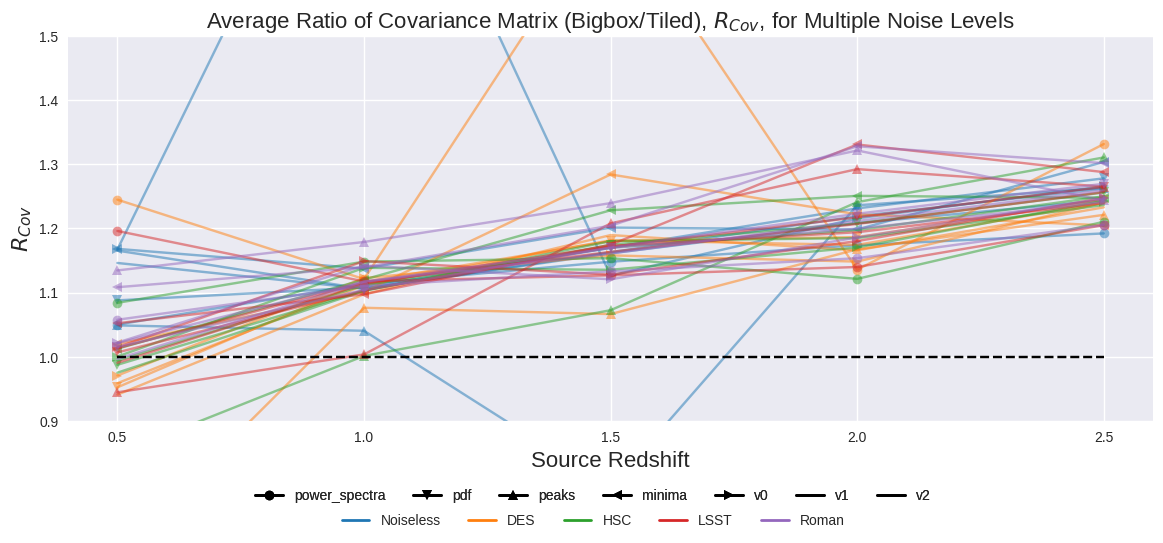

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

ax.set_title("Average Ratio of Covariance Matrix (Bigbox/Tiled), $R_{Cov}$, for Multiple Noise Levels", fontsize=16)

for i, ngal_i in enumerate(ngal_list):
    ngal = f"ngal_{ngal_i}"
    for j, label in enumerate(labels):
        ax.plot(zs_list, avgs_cov[ngal][label], label=label, color=colors[i], linestyle="-", marker=markers[j], alpha=0.5)

custom_lines2 = [Line2D([0], [0], marker=markers[i], color="black", lw=2) for i in range(len(labels))]
legend2 = fig.legend(custom_lines2, labels, ncol=len(labels), bbox_to_anchor=(0.5, 0), loc='upper center')

fig.add_artist(legend2)

custom_lines1 = [Line2D([0], [0], color=colors[i], lw=2) for i in range(len(ngal_list))]
fig.legend(custom_lines1, [survey_info[str(ngal)] for ngal in ngal_list], ncol=len(ngal_list), bbox_to_anchor=(0.5, -0.05), loc='upper center')

ax.hlines(1, 0.5, 2.5, color="black", linestyle="--")

ax.set_xticks(zs_list)

ax.set_ylim(0.9, 1.5)

ax.set_xlabel("Source Redshift", fontsize=16)
ax.set_ylabel("$R_{Cov}$", fontsize=16)

fig.savefig(savedir + "/avg_cov_ratio_noise.png", bbox_inches='tight')

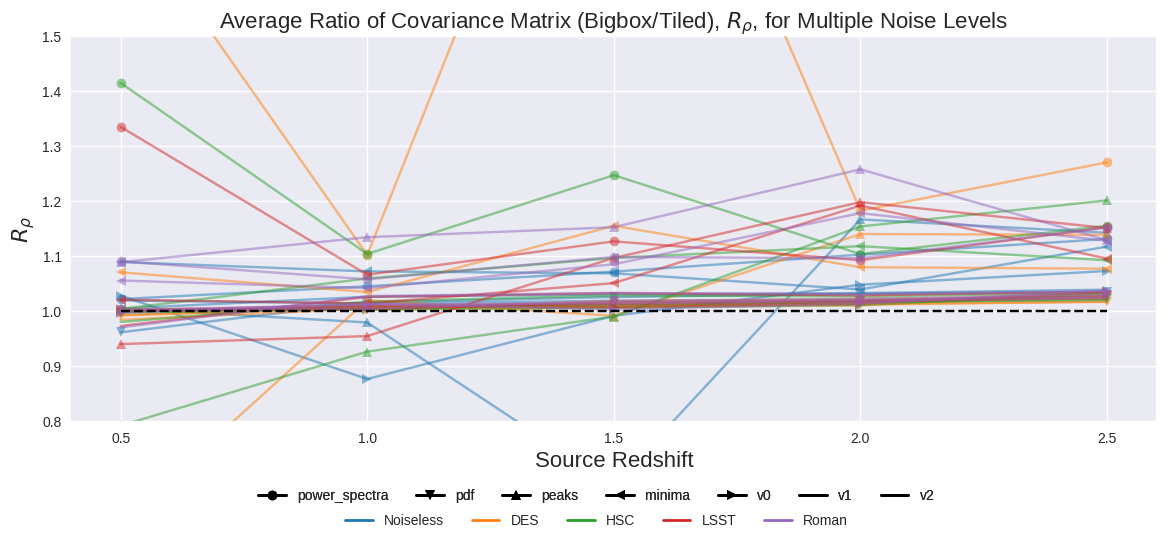

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

ax.set_title(r"Average Ratio of Covariance Matrix (Bigbox/Tiled), $R_\rho$, for Multiple Noise Levels", fontsize=16)

for i, ngal_i in enumerate(ngal_list):
    ngal = f"ngal_{ngal_i}"
    for j, label in enumerate(labels):
        ax.plot(zs_list, avgs_corr[ngal][label], label=label, color=colors[i], linestyle="-", marker=markers[j], alpha=0.5)

custom_lines2 = [Line2D([0], [0], marker=markers[i], color="black", lw=2) for i in range(len(labels))]
legend2 = fig.legend(custom_lines2, labels, ncol=len(labels), bbox_to_anchor=(0.5, 0), loc='upper center')

fig.add_artist(legend2)

custom_lines1 = [Line2D([0], [0], color=colors[i], lw=2) for i in range(len(ngal_list))]
fig.legend(custom_lines1, [survey_info[str(ngal)] for ngal in ngal_list], ncol=len(ngal_list), bbox_to_anchor=(0.5, -0.05), loc='upper center')

ax.hlines(1, 0.5, 2.5, color="black", linestyle="--")

ax.set_xticks(zs_list)

ax.set_ylim(0.8, 1.5)

ax.set_xlabel("Source Redshift", fontsize=16)
ax.set_ylabel(r"$R_\rho$", fontsize=16)

fig.savefig(savedir + "/avg_corr_ratio_noise.png", bbox_inches='tight')

In [183]:
smoothing_info = {
    '2': 'Sl = 2',
    '5': 'Sl = 5',
    '8': 'Sl = 8',
    '10': 'Sl = 10'
}

In [184]:
except_indices=[(1, nbin-1), (1, nbin-1), (1, nbin-1), (1, nbin-1), (1, nbin-1), (1, nbin-1)]

except_indices=[(1, nbin-1), (1, nbin-1), (1, nbin-1), (1, nbin-1), (1, nbin-1), (1, nbin-1)]

# Initialize dictionaries to store average ratios for different smoothing lengths
ngal = "ngal_0"  # Using noiseless case

avgs_cov = {}
avgs_corr = {}

# Process data for each smoothing length
for sl_i in sl_list:
    sl = f"sl_{sl_i}"
    avgs_cov[sl] = {}
    avgs_corr[sl] = {}
    
    # Process data for each redshift
    for i, zs_i in enumerate(zs_list):
        # Process nu-binned statistics (PDF, peaks, minima, MFs)
        for j, label in enumerate(labels_nu):
            # Initialize lists if not already done
            if label not in avgs_cov[sl]:
                avgs_cov[sl][label] = []
            if label not in avgs_corr[sl]:
                avgs_corr[sl][label] = []
            
            # Define range of bins to use (exclude edges)
            rmin, rmax = except_indices[j]
            
            if (('bigbox', zs_i) in covariances and (ngal, sl) in covariances[('bigbox', zs_i)] and
                ('tiled', zs_i) in covariances and (ngal, sl) in covariances[('tiled', zs_i)]):
                if label in covariances[('bigbox', zs_i)][(ngal, sl)] and label in covariances[('tiled', zs_i)][(ngal, sl)]:
                    # Get covariance matrices
                    bigbox_cov = covariances[('bigbox', zs_i)][(ngal, sl)][label]
                    tiled_cov = covariances[('tiled', zs_i)][(ngal, sl)][label]
                    
                    # Get correlation matrices
                    bigbox_corr = correlations[('bigbox', zs_i)][(ngal, sl)][label]
                    tiled_corr = correlations[('tiled', zs_i)][(ngal, sl)][label]
                    
                    # Special handling for minima
                    if label == "minima":
                        bigbox_cov = bigbox_cov[::-1, ::-1]
                        tiled_cov = tiled_cov[::-1, ::-1]
                        bigbox_corr = bigbox_corr[::-1, ::-1]
                        tiled_corr = tiled_corr[::-1, ::-1]
                    
                    # Calculate ratios
                    cov_ratio = bigbox_cov / tiled_cov
                    corr_ratio = bigbox_corr / tiled_corr
                    
                    # Calculate means of ratios in the specified range
                    avgs_cov[sl][label].append(safe_mean(cov_ratio[rmin:rmax, rmin:rmax]))
                    avgs_corr[sl][label].append(cal_corr_avg(corr_ratio[rmin:rmax, rmin:rmax]))

/var/tmp/pbs.414522.idark/ipykernel_251444/1343220472.py:49: RuntimeWarning: invalid value encountered in true_divide
  cov_ratio = bigbox_cov / tiled_cov
/var/tmp/pbs.414522.idark/ipykernel_251444/1343220472.py:49: RuntimeWarning: divide by zero encountered in true_divide
  cov_ratio = bigbox_cov / tiled_cov


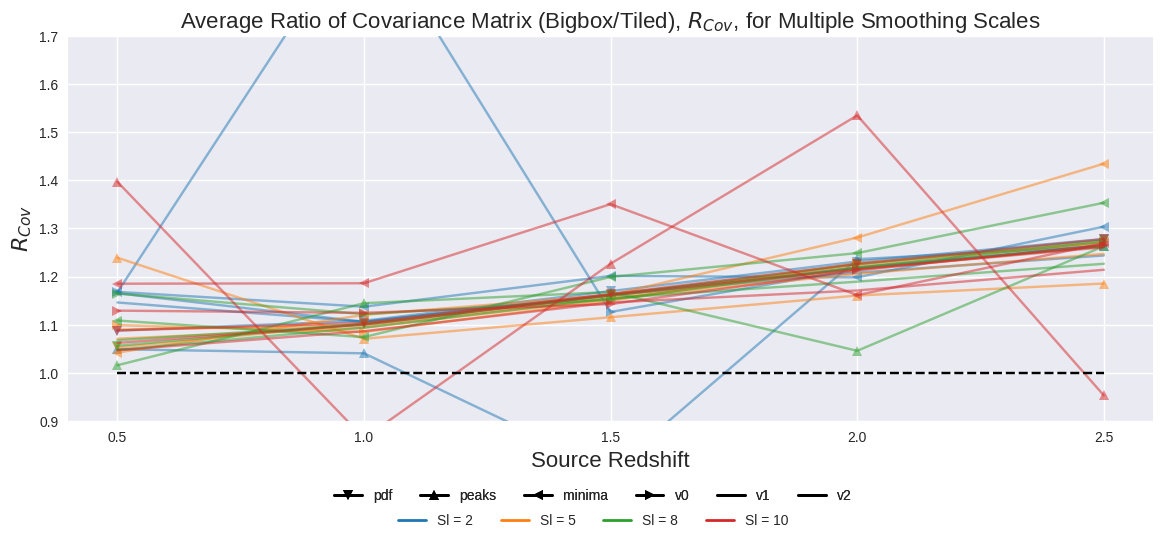

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

ax.set_title(r"Average Ratio of Covariance Matrix (Bigbox/Tiled), $R_{Cov}$, for Multiple Smoothing Scales", fontsize=16)

for i, sl_i in enumerate(sl_list):
    sl = f"sl_{sl_i}"
    for j, label in enumerate(labels_nu):
        ax.plot(zs_list, avgs_cov[sl][label], label=label, color=colors[i], linestyle="-", marker=markers[1:][j], alpha=0.5)

custom_lines2 = [Line2D([0], [0], marker=markers[1:][i], color="black", lw=2) for i in range(len(labels_nu))]
legend2 = fig.legend(custom_lines2, labels_nu, ncol=len(labels_nu), bbox_to_anchor=(0.5, 0), loc='upper center')

fig.add_artist(legend2)

custom_lines1 = [Line2D([0], [0], color=colors[i], lw=2) for i in range(len(sl_list))]
fig.legend(custom_lines1, [smoothing_info[str(sl)] for sl in sl_list], ncol=len(sl_list), bbox_to_anchor=(0.5, -0.05), loc='upper center')

ax.hlines(1, 0.5, 2.5, color="black", linestyle="--")

ax.set_xticks(zs_list)

ax.set_ylim(0.9, 1.7)

ax.set_xlabel("Source Redshift", fontsize=16)
ax.set_ylabel("$R_{Cov}$", fontsize=16)

fig.savefig(savedir + "/avg_cov_ratio_sl.png", bbox_inches='tight')

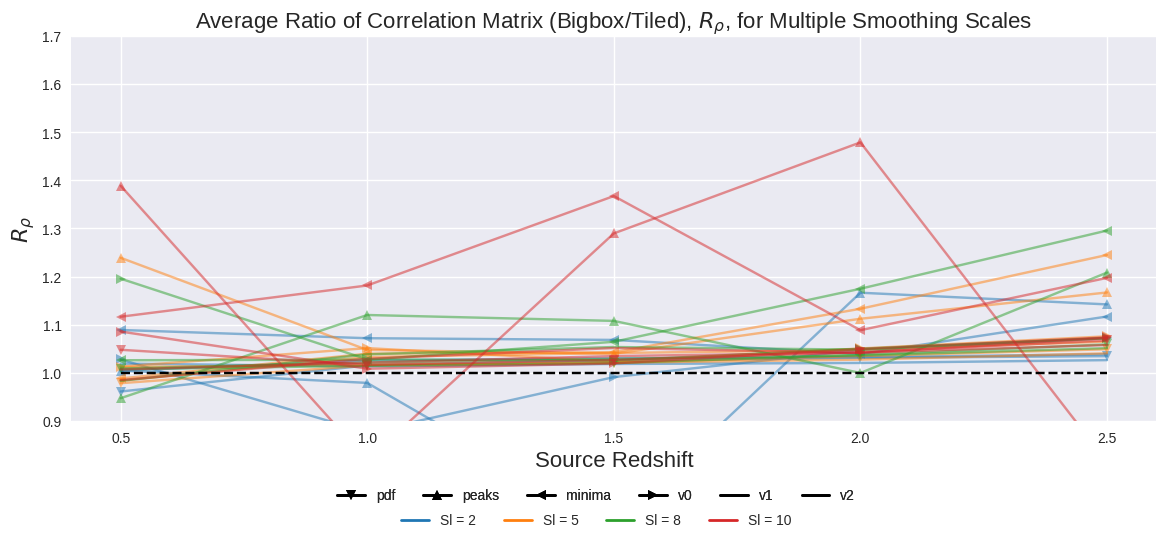

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

ax.set_title(r"Average Ratio of Correlation Matrix (Bigbox/Tiled), $R_\rho$, for Multiple Smoothing Scales", fontsize=16)

for i, sl_i in enumerate(sl_list):
    sl = f"sl_{sl_i}"
    for j, label in enumerate(labels_nu):
        ax.plot(zs_list, avgs_corr[sl][label], label=label, color=colors[i], linestyle="-", marker=markers[1:][j], alpha=0.5)

custom_lines2 = [Line2D([0], [0], marker=markers[1:][i], color="black", lw=2) for i in range(len(labels_nu))]
legend2 = fig.legend(custom_lines2, labels_nu, ncol=len(labels_nu), bbox_to_anchor=(0.5, 0), loc='upper center')

fig.add_artist(legend2)

custom_lines1 = [Line2D([0], [0], color=colors[i], lw=2) for i in range(len(sl_list))]
fig.legend(custom_lines1, [smoothing_info[str(sl)] for sl in sl_list], ncol=len(sl_list), bbox_to_anchor=(0.5, -0.05), loc='upper center')

ax.hlines(1, 0.5, 2.5, color="black", linestyle="--")

ax.set_xticks(zs_list)

ax.set_ylim(0.9, 1.7)

ax.set_xlabel("Source Redshift", fontsize=16)
ax.set_ylabel(r"$R_\rho$", fontsize=16)

fig.savefig(savedir + "/avg_corr_ratio_sl.png", bbox_inches='tight')